# SAP-FI-Data Analysis

<br> Content: 
<br> 1. Import Modules
<br> 2. Data Preparation:
<br>   • Data Extraction
<br>   • Handling Data Types
<br>   • Handling Missing Values
<br>   • Adding New Features

<br> 3. Data Analysis:
<br>   • Exploring Data
<br>   • Financial Data Analysis
<br>   • Statistical Analysis (Anomaly Detection)


<br> Data Used: Artificially Created SAP-FI Tables (BKPF, BSEG, T001, SKAT, T003T)

# 1. Import Modules

In [34]:
import pandas as pd  #!pip install pandas==1.5.3
import numpy as np

In [35]:
# to avoid hidding rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None) # for long text columns needed, e.g. description of GL Accounts.

In [36]:
# To hide warnings
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Modules for Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns   #!pip install seaborn==0.11.2
sns.set(style="whitegrid")

# 2.Preparing Data

##### Data Extraction

In [39]:
# GitHub raw file URL
data_path = r"https://raw.githubusercontent.com/mahho0000/SAP-FI-DATA-101/main/data/"

In [41]:
# Read data
BKPF_df = pd.read_excel(data_path + "BKPF.xlsx")
BKPF_df.shape

(100224, 8)

In [42]:
BSEG_df = pd.read_excel(data_path + "BSEG.xlsx")
BSEG_df.shape

(200448, 14)

In [43]:
#join BKPF and BSEG
merging_keys = ["MANDT", "BUKRS", "BELNR"] # also recommended to use GJAHR (Fiscal Year). Here we have just 1y data thus we do not use
df = BKPF_df.merge(BSEG_df, on=merging_keys,  how='left')
df.shape

(200448, 19)

In [44]:
new_header = {'MANDT':'Client', 'BUKRS':'CompCode', 'BELNR':'DocNum', 'BUDAT':'PostDate',
              'WAERS':'DocCurr', 'HWAER':'LocCurr', 'HWAE2':'Loc2Curr', 'BLART':'DocType',
              'WRBTR':'AmountDC', 'DMBTR':'AmountLC', 'DMBE2':'AmountLC2',
              'BUZEI':'LineItem', 'SHKZG':'DrCrInd', 'KOART':'AccountType', 'HKONT':'GlAccount',
              'KUNNR':'Customer', 'LIFNR':'Vendor', 'ANLN1':'Asset', 'KOSTL':'CostCenter'}

df= df.rename(columns=new_header)

##### Handling Data TYpes

In [45]:
df["Client"] =  df["Client"].astype(object)
df["CompCode"] =  df["CompCode"].astype(object)
df["DocNum"] =  df["DocNum"].astype(object)

In [46]:
df['PostDate'] = pd.to_datetime(df['PostDate'], format ='%Y-%m-%d', errors = 'coerce')

In [47]:
df["DocCurr"] =  df["DocCurr"].astype("category")
df["LocCurr"] =  df["LocCurr"].astype("category")
df["Loc2Curr"] =  df["Loc2Curr"].astype("category")

df["AmountDC"] =  df["AmountDC"].astype("Float64")
df["AmountLC"] =  df["AmountLC"].astype("Float64")
df["AmountLC2"] =  df["AmountLC2"].astype("Float64")

In [48]:
df["DocType"] =  df["DocType"].astype("category")
df["LineItem"] =  df["LineItem"].astype("Int16") # recommend keep it in integer since it might be used for looping and sorting
df["DrCrInd"] =  df["DrCrInd"].astype("category")
df["AccountType"] =  df["AccountType"].astype("category")
df["GlAccount"] =  df["GlAccount"].astype(str).str.lstrip('0').str.replace('\.0$', '')  #remove zeros from left side and ".0" at end
df["Customer"] =  df["Customer"].astype(str).str.lstrip('0').str.replace('\.0$', '')  
df["Vendor"] =  df["Vendor"].astype(str).str.lstrip('0').str.replace('\.0$', '')  
df["Asset"] =  df["Asset"].astype(str).str.lstrip('0').str.replace('\.0$', '')  
df["CostCenter"] =  df["CostCenter"].astype(str).str.lstrip('0').str.replace('\.0$', '')

##### Missing Values

In [49]:
# checking if data contains any np.nan (which is ookey for some fields but not for all)
df[df.isna().any(axis=1)].head(2)

Empty DataFrame
Columns: [Client, CompCode, DocNum, PostDate, DocCurr, LocCurr, Loc2Curr, DocType, AmountDC, AmountLC, AmountLC2, LineItem, DrCrInd, AccountType, GlAccount, Customer, Vendor, Asset, CostCenter]
Index: []

In [50]:
# NaN as a string
df[df.isin(['nan']).any(axis=1)].head(2)

Client CompCode    DocNum   PostDate DocCurr LocCurr Loc2Curr DocType  \
0    100     GER1  70000000 2021-08-24     PLN     EUR      EUR      SA   
1    100     GER1  70000000 2021-08-24     PLN     EUR      EUR      SA   

   AmountDC  AmountLC  AmountLC2  LineItem DrCrInd AccountType GlAccount  \
0   96990.0   21338.0    21338.0         2      Cr           S     55000   
1   96990.0   21338.0    21338.0         1      Dr           S     10000   

  Customer Vendor Asset CostCenter  
0      nan    nan   nan    CCI4002  
1      nan    nan   nan        nan

In [51]:
# replacing string 'nan' with np.nan
df["Customer"] =  df["Customer"].replace('nan', np.nan)
df["Vendor"] =  df["Vendor"].replace('nan', np.nan)
df["Asset"] =  df["Asset"].replace('nan', np.nan)
df["CostCenter"] =  df["CostCenter"].replace('nan', np.nan)

df[df.isin(['nan']).any(axis=1)].shape[0]

0

In [52]:
# Checking fields that MUST NOT contain missing values
Non_NA_Cols = ['Client', 'CompCode', 'DocNum', 'PostDate', 'DocCurr', 'LocCurr',
       'Loc2Curr', 'DocType', 'AmountDC', 'AmountLC', 'AmountLC2', 'LineItem',
       'DrCrInd', 'AccountType', 'GlAccount']

df[(df[Non_NA_Cols].isna().any(axis=1))].shape[0] #must not have NULL

0

P&L Entry Requirement: 
<br> Each item in the Profit and Loss (P&L) accounts should be linked to either a cost object (Cost Center, WBS, etc.) or profit center. In our scenario, where only cost centers apply. Checking whether all cost centers are accurately filled. 

In [53]:
# Checking if Cost/Profit Objects are missing in P&L Accounts Lines (here only Cost Center)
# Usually Cost Objects are for Expenditure Lines, Profit Centers are for Revenues.
PL_Acc_First_Dig = ('4', '5', '6', '7') # P&L Accounts First Digits
df.loc[(df["GlAccount"].str.startswith(PL_Acc_First_Dig) & df["CostCenter"].isna())].head() # must be no lines

Empty DataFrame
Columns: [Client, CompCode, DocNum, PostDate, DocCurr, LocCurr, Loc2Curr, DocType, AmountDC, AmountLC, AmountLC2, LineItem, DrCrInd, AccountType, GlAccount, Customer, Vendor, Asset, CostCenter]
Index: []

##### Adding New Features

In [54]:
# Checking Posting Date range for our dataset
min_posting_date = df["PostDate"].dt.date.min()
max_posting_date = df["PostDate"].dt.date.max()
print(f"Posting Date range: {min_posting_date} <> {max_posting_date}")

Posting Date range: 2021-01-01 <> 2021-12-31


In [55]:
# Create Period feature
df['Period'] = df['PostDate'].dt.month.astype('Int8')       

#Here we are adding Period. It is advisable to retrieve this information from BKPF_MONAT for better differentiation among periods 13-16.

In [56]:
min_posting_period = df["Period"].min()
max_posting_period = df["Period"].max()
print(f"Posting Period range: {min_posting_period} <> {max_posting_period}")

Posting Period range: 1 <> 12


In [57]:
# New UniqueID feature. 
df["UniqueID"] = df.Client.astype(str) + df.CompCode.astype(str) + df.DocNum.astype(str) # + df.Year.astype(str)


#Creating UniqueID feature to identify documents accross clients, Company Codes and FiScal years.
# We exclude Fiscal Year only because we have 1 year data here 

In [58]:
# LC2 Value column to have both negative and positive values 

'''In BSEG, amount fields store absolute value. 
<br> Creating Feature Storing LC2 Value , both negative and positive using Dr/Cr indicators. 
<br> You can do it for other currency key amounts as well'''


df["Dr_Cr_Val"] = df["DrCrInd"].map({"Dr": 1, "Cr": -1}).astype("Int16")
df["AmountLC2_Val"] = df["Dr_Cr_Val"] * df["AmountLC2"]
del df["Dr_Cr_Val"]

Creating Function to easily add Document Type Description Field whenever it will be needed. 

In [59]:
# Table storing Document Type Texts (Description)
T003T_df = pd.read_excel(data_path + "T003T.xlsx")
T003T_df.shape

(22, 4)

In [60]:
T003T_header = {'MANDT':'Client', 'SPRAS':'LangKey', 'BLART':'DocType',
              'LTEXT':'DocTypeDesc'}
T003T_df= T003T_df.rename(columns=T003T_header)

In [61]:
# Function to add Document Type Descriptions whenever needed
def doc_ty_desc_func(data):
    new_data = data.merge(T003T_df.loc[T003T_df["LangKey"]=="E", ["Client","DocType","DocTypeDesc"]], on=["Client","DocType"], how='left')
    return new_data

Creating Function to add GL Account Description Field SKAT_TXT50 whenever it will be needed.

In [62]:
# Table storing information about Company Codes. Wewill use to get Chart of Accounts
T001_df = pd.read_excel(data_path + "T001.xlsx")
T001_df = T001_df.rename(columns={"MANDT": "Client",
                                  "BUKRS"  : "CompCode",
                                  "KTOPL": "ChartOfAccounts"})
T001_df.shape

(12, 6)

In [63]:
# Table storing GL Account Text (Description). Chart of Accounts field is needed for merging with BSEG
SKAT_df = pd.read_excel(data_path + "SKAT.xlsx")
SKAT_df = SKAT_df.rename(columns={"MANDT": "Client",
                                  "KTOPL"  : "ChartOfAccounts",
                                  "SAKNR"  : "GlAccount",
                                  "TXT50": "GL_Account_Desc"})
SKAT_df["GlAccount"] =  SKAT_df["GlAccount"].astype(str).str.lstrip('0').str.replace('\.0$', '')  #remove zeros from left side and ".0" at end
SKAT_df.shape

(258, 5)

In [64]:
# Function to add GL Account Descriptions whenever needed
def add_gl_desc_func(data):
    new_data = data.merge(T001_df[["Client","CompCode","ChartOfAccounts"]], on=["Client","CompCode"], how='left')
    new_data = new_data.merge(SKAT_df[["Client","ChartOfAccounts","GlAccount","GL_Account_Desc"]], on=["Client","ChartOfAccounts", "GlAccount"], how='left')
    del new_data["ChartOfAccounts"]
    return new_data

# 3. Data Analysis

## 3.1. Exploring Data 

##### Validating Accounting Principles

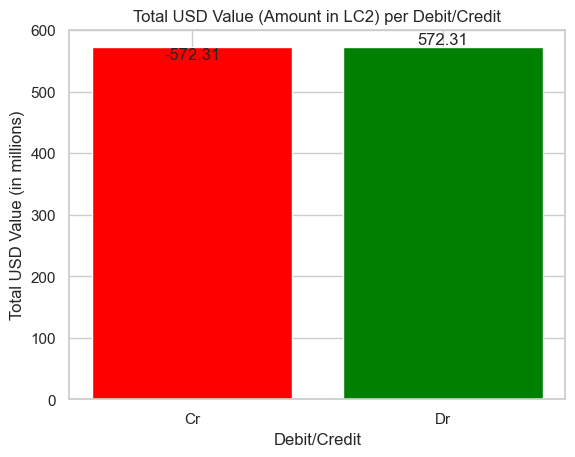

In [35]:
# Checking if Total Values for Debit and Credit re matching

# Group by 'DrCrInd' and sum the 'AmountLC2_Val'
grouped_data = df.groupby('DrCrInd')['AmountLC2_Val'].sum() / 1e6  # Dividing by 1e6 to show values in millions

fig, ax = plt.subplots()
bars = ax.bar(grouped_data.index, abs(grouped_data.values), color=['red', 'green'])

# Display total values on top of each bar
for bar, value in zip(bars, grouped_data.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{value:.2f}', ha='center', va='bottom' if value >= 0 else 'top')

# Set up labels and title
plt.title('Total USD Value (Amount in LC2) per Debit/Credit')
plt.xlabel('Debit/Credit')
plt.ylabel('Total USD Value (in millions)')
plt.show()

In [36]:
#Checking Whether Assets =  Liability + Equity
ITA2_Assets = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")&(df["GlAccount"].str.startswith(('1'))), "AmountLC2_Val"].sum()
ITA2_Liabilities = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")&(df["GlAccount"].str.startswith(('2'))), "AmountLC2_Val"].sum()
ITA2_Equity = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")&(df["GlAccount"].str.startswith(('3'))), "AmountLC2_Val"].sum()

print(f"Total Assets: {ITA2_Assets}  | Total Liabilities + Equity: {ITA2_Liabilities+ITA2_Equity}")

Total Assets: 34044.0  | Total Liabilities + Equity: -34044.0


<br> • The amounts for debit and credit values match up. 
<br> • This balance follows the basic accounting idea that Assets equal Liabilities plus Equity. 
<br> • These are one of the crucial signs indicating that our data is in good shape—showing that we've got accurate and complete information.

##### Value and Volume of Postings per Clients and Company Codes

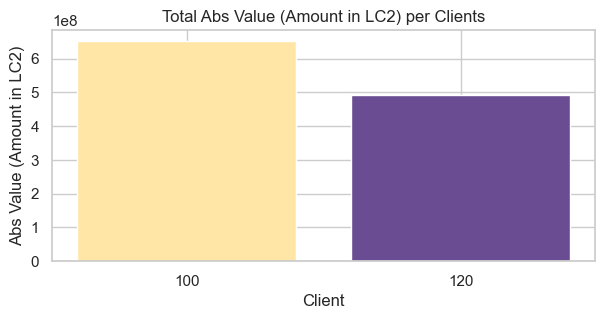

In [38]:
#Checking Total LC2 Values per Clients
grouped_data = df.groupby('Client')['AmountLC2'].sum()
clients_ls = [str(client) for client in list(grouped_data.index)]

plt.figure(figsize=(7, 3))
plt.bar(clients_ls, grouped_data.values, color=['#ffe6a7', '#6a4c93'])
plt.title('Total Abs Value (Amount in LC2) per Clients')
plt.xlabel('Client')
plt.ylabel('Abs Value (Amount in LC2)')
plt.show()

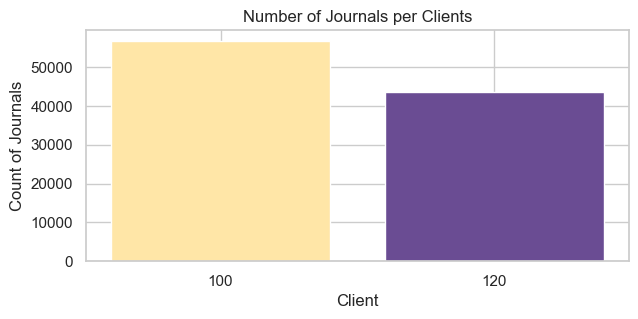

In [40]:
# Checking Total number of Postings per Clients
grouped_data = df.groupby('Client')['UniqueID'].nunique()
clients_ls = [str(client) for client in list(grouped_data.index)]

plt.figure(figsize=(7, 3))
plt.bar(clients_ls, grouped_data.values, color=['#ffe6a7', '#6a4c93'])
plt.title('Number of Journals per Clients')
plt.xlabel('Client')
plt.ylabel('Count of Journals')
plt.show()

A higher volume and value of postings are observed in client 100 compared to client 120.

Postings Per Company Codes

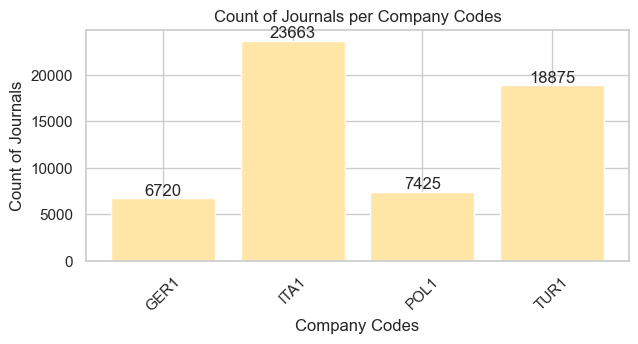

In [41]:
# Count of Journals per All Company Codes
clt100_df = df.loc[df["Client"]==100]
grouped_data = clt100_df.groupby('CompCode')['UniqueID'].nunique()
fig, ax = plt.subplots(figsize=(7, 3))
bars = ax.bar(grouped_data.index, grouped_data.values, color='#ffe6a7')  # You can change the color as needed
# Display count of journals on top of each bar
for bar, count in zip(bars, grouped_data.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{count}', ha='center', va='bottom' if count >= 0 else 'top')

plt.title('Count of Journals per Company Codes')
plt.xlabel('Company Codes')
plt.ylabel('Count of Journals')
plt.xticks(rotation=45)
plt.show()

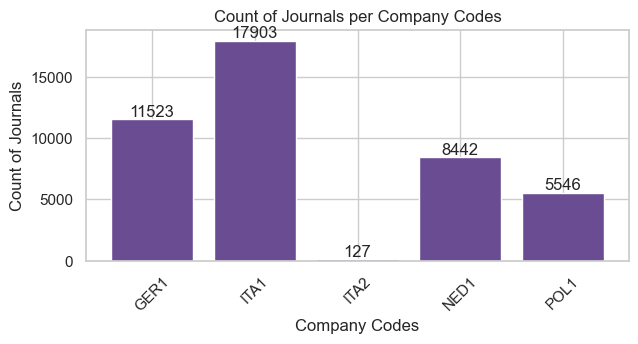

In [42]:
# Count of Journals per All Company Codes
clt100_df = df.loc[df["Client"]==120]
grouped_data = clt100_df.groupby('CompCode')['UniqueID'].nunique()
fig, ax = plt.subplots(figsize=(7, 3))
bars = ax.bar(grouped_data.index, grouped_data.values, color='#6a4c93')  # You can change the color as needed
# Display count of journals on top of each bar
for bar, count in zip(bars, grouped_data.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{count}', ha='center', va='bottom' if count >= 0 else 'top')

plt.title('Count of Journals per Company Codes')
plt.xlabel('Company Codes')
plt.ylabel('Count of Journals')
plt.xticks(rotation=45)
plt.show()

The bulk of postings are within the company code ITA1, with fewer entries in ITA2. It's crucial to understand that the data for all company codes is synthetic. ITA2 was manually crafted for financial analysis, whereas the others were auto-generated using code.

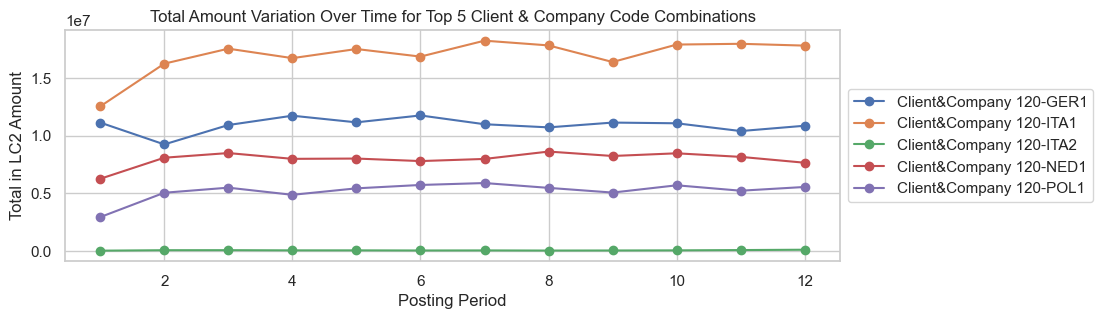

In [43]:
# Calculating Total Amounts variation Over Time
clt100_df = df.loc[df["Client"]==120]
grouped_data = clt100_df.groupby(['Client', 'CompCode', 'Period'])['AmountLC2'].sum().reset_index()

# Get the top 5 client and company code combinations
top_5_combinations = grouped_data.groupby(['Client', 'CompCode'])['AmountLC2'].sum().nlargest(5).index

plt.figure(figsize=(10, 3))
for (client, company_code), data in grouped_data[grouped_data.set_index(['Client', 'CompCode']).index.isin(top_5_combinations)].groupby(['Client', 'CompCode']):
    plt.plot(data['Period'], data['AmountLC2'], marker='o', label=f'Client&Company {client}-{company_code}')

plt.title('Total Amount Variation Over Time for Top 5 Client & Company Code Combinations')
plt.xlabel('Posting Period')
plt.ylabel('Total in LC2 Amount')

plt.grid(True)
plt.xticks(rotation=0)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

NOTE: 1e7 is 1 × 10**7 = 10 mln 

##### Volume of Postings per Periods

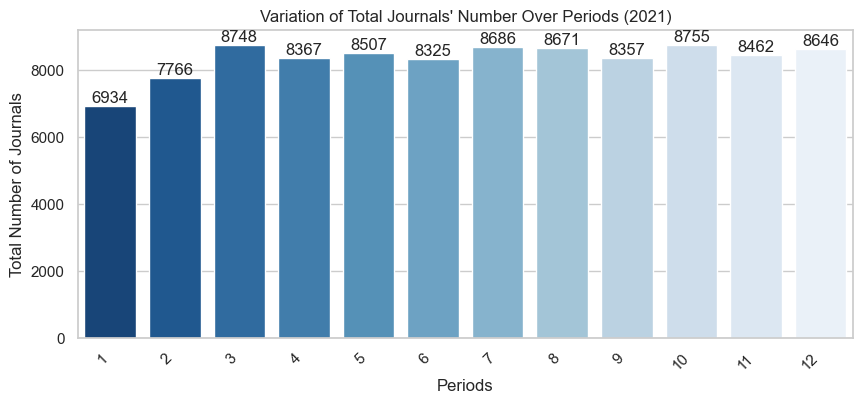

In [44]:
# Calculating Total Count of Journals Over Periods (data contains only 2021 Fiscal Year)

grouped_data = df.groupby('Period')['UniqueID'].nunique().reset_index(name='Count')

plt.figure(figsize=(10, 4))
sns.barplot(x='Period', y='Count', data=grouped_data, palette="Blues_r")

plt.title("Variation of Total Journals' Number Over Periods (2021)")
plt.xlabel('Periods')
plt.ylabel('Total Number of Journals')

# Display the count values on top of each bar
for index, value in enumerate(grouped_data['Count']):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.show()

you can add extra features like "approved via system or manually", "manuall entry or automatic or semi-automatic", "risky accounts "  , etc. to see more details and understand more about the data

##### GL Accounts (Continued on Financial Data Analysis)

In [45]:
ITA2_df = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")]
grp_GL_col = ["Client","CompCode","GlAccount"]
grouped_data = ITA2_df.groupby(grp_GL_col).agg(
        Total_AmountLC2 = ('AmountLC2_Val','sum'),
        Total_lines = ('DocNum','count')   #not unique journals, but journal lines
    ).reset_index()

grouped_data = grouped_data.sort_values(by=['Total_AmountLC2', 'Total_lines'], ascending=False, na_position='first', ignore_index=True)
grouped_data.shape

(14, 5)

In [46]:
grouped_data = add_gl_desc_func(data=grouped_data)
grouped_data.shape

(14, 6)

In [47]:
grouped_data["GLAcc_wtDesc"] = grouped_data.GlAccount.astype(str) + ": " + grouped_data.GL_Account_Desc.astype(str)
grouped_data = grouped_data.sort_values(by='GLAcc_wtDesc', ascending=True, na_position='first')
grouped_data.head(3)

Client CompCode GlAccount  Total_AmountLC2  Total_lines  \
0      120     ITA2     10000          45100.0           50   
10     120     ITA2     12000         -10000.0           26   
7      120     ITA2     13000              0.0           24   

                        GL_Account_Desc  \
0                           Bank (Cash)   
10                            Inventory   
7   Trade Debtors (Accounts Receivable)   

                                  GLAcc_wtDesc  
0                           10000: Bank (Cash)  
10                            12000: Inventory  
7   13000: Trade Debtors (Accounts Receivable)

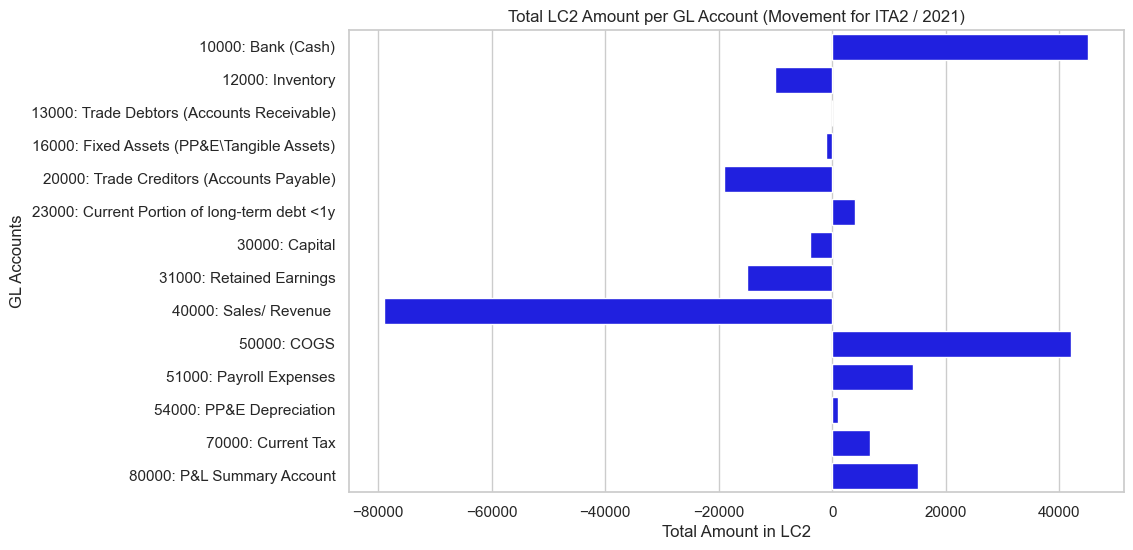

In [48]:
# Visualize total LC2 Amount per GL Account
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_AmountLC2', y='GLAcc_wtDesc', data=grouped_data, color="blue")

plt.title('Total LC2 Amount per GL Account (Movement for ITA2 / 2021)')
plt.xlabel('Total Amount in LC2')# Set the color for the x-axis
plt.ylabel('GL Accounts')

plt.show()

The absence of Accounts Receivable (AR) balance raises question. In a scenario involving revenue and bank account transactions, the likelihood of not having trade receivables is considerably low. 

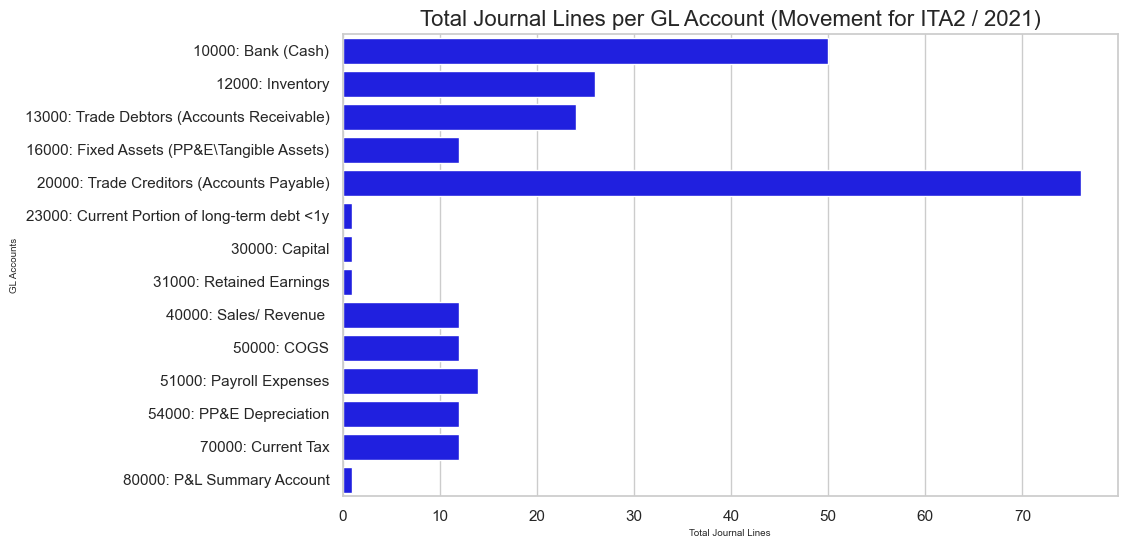

In [49]:
# Visualize total Lines Posted per GL Account
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_lines', y='GLAcc_wtDesc', data=grouped_data, color="blue")

plt.title('Total Journal Lines per GL Account (Movement for ITA2 / 2021)', fontsize=16)
plt.xlabel('Total Journal Lines', fontsize=7)  # Set the color for the x-axis
plt.ylabel('GL Accounts', fontsize=7)

plt.show()

However, upon visualizing volumes (total number of posting lines), it becomes apparent that there are AR lines present. This discrepancy is interesting and raises a question: Why we dont have AR balance, and what is the source of Revenue then if we dont get any AR. We will further check it in Financial Data Analysis part.

##### Expenditures in Group Currency

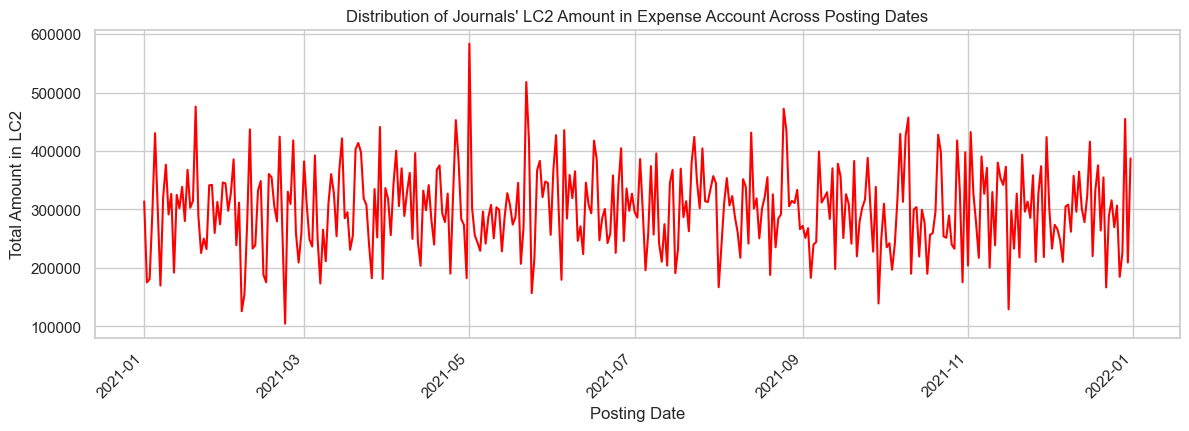

In [51]:
# Visualize Documents LC2 Amount in Expense Account Accros Posting Dates

# get P&L Expense Account
expense_df = df.loc[(df["GlAccount"].astype(str).str[:1].astype(int)==5)]
grouped_data = expense_df.groupby('PostDate')['AmountLC2_Val'].sum()

plt.figure(figsize=(14,4))
sns.lineplot(x=grouped_data.index, y=grouped_data.values, color="red")

plt.title("Distribution of Journals' LC2 Amount in Expense Account Across Posting Dates")
plt.xlabel('Posting Date')
plt.ylabel('Total Amount in LC2')

plt.xticks(rotation=45, ha='right')

plt.show()

Something unusual has popped up in the group report—big expenses showing up in May or at the end of April. Let's take a closer look to figure out what's going on during these times and why the costs are spiking. This investigation will help us understand the reasons behind these higher expenses.

In [52]:
expense_p4_5_may_df = expense_df.loc[expense_df["Period"].isin((4,5))]
grouped_df = expense_p4_5_may_df.groupby("PostDate").agg(
        Sum_Journals = ('AmountLC2_Val','sum')
    ).reset_index()

grouped_df = grouped_df.sort_values(by='Sum_Journals', ascending=False, na_position='first')

In [103]:
grouped_df.head(10)

PostDate  Sum_Journals
30 2021-05-01      583641.0
51 2021-05-22      517929.0
25 2021-04-26      452820.0
52 2021-05-23      416815.0
3  2021-04-04      400552.0
10 2021-04-11      396424.0
26 2021-04-27      384904.0
56 2021-05-27      383096.0
19 2021-04-20      375274.0
5  2021-04-06      370387.0

In [54]:
may01_df = expense_df.loc[expense_df["PostDate"]== pd.to_datetime('2021-05-01')]
print(f'Total LC2 for 2021-05-01: {may01_df["AmountLC2_Val"].sum()}')
may01_df.shape

Total LC2 for 2021-05-01: 583641.0


(112, 22)

In [55]:
may01_df["AmountLC2_Val"].describe()

count      112.000000
mean      5211.080357
std       8254.103129
min     -19173.000000
25%       1508.750000
50%       4633.000000
75%       8479.750000
max      35558.000000
Name: AmountLC2_Val, dtype: float64

Something seems off with unusually large amounts, especially when comparing the maximum value to the 75th percentile. Let's investigate the most substantial postings in this context to understand the nature of these significant figures. 

In [56]:
may01_df = may01_df.sort_values(by='AmountLC2_Val', ascending=False, na_position='first')
may01_df.head(10)

Client CompCode    DocNum   PostDate DocCurr LocCurr Loc2Curr DocType  \
95619     120     GER1  70009235 2021-05-01     PLN     EUR      EUR      KR   
65840     100     ITA1  70005612 2021-05-01     PLN     EUR      EUR      SA   
86415     120     GER1  70000087 2021-05-01     PLN     EUR      EUR      KR   
116432    120     ITA1  70008630 2021-05-01     PLN     EUR      EUR      SA   
119492    120     ITA1  70003172 2021-05-01     PLN     EUR      EUR      SA   
59701     100     ITA1  70001809 2021-05-01     PLN     EUR      EUR      SA   
83708     120     GER1  70006889 2021-05-01     PLN     EUR      EUR      SA   
65341     100     ITA1  70000612 2021-05-01     PLN     EUR      EUR      SA   
80046     100     ITA1  70013279 2021-05-01     PLN     EUR      EUR      SA   
123043    120     ITA1  70001144 2021-05-01     PLN     EUR      EUR      SA   

        AmountDC  AmountLC  AmountLC2  LineItem DrCrInd AccountType GlAccount  \
95619   161626.0   35558.0    35558.0         2      Dr           S     51000   
65840   133367.0   33321.0    33321.0         1      Dr           S     53000   
86415   120759.0   28507.0    28507.0         2      Dr           S     51000   
116432   90475.0   19905.0    19905.0         1      Dr           S     55000   
119492   88549.0   19481.0    19481.0         1      Dr           S     55000   
59701    84333.0   18553.0    18553.0         1      Dr           S     53000   
83708    84017.0   18484.0    18484.0         1      Dr           S     55000   
65341    82394.0   18127.0    18127.0         1      Dr           S     53000   
80046    81402.0   17908.0    17908.0         1      Dr           S     55000   
123043   81294.0   17885.0    17885.0         1      Dr           S     55000   

       Customer Vendor Asset CostCenter  Period         UniqueID  \
95619       NaN    NaN   NaN    CCX5001       5  120GER170009235   
65840       NaN    NaN   NaN    CCX3002       5  100ITA170005612   
86415       NaN    NaN   NaN    CCX5000       5  120GER170000087   
116432      NaN    NaN   NaN    CCX5001       5  120ITA170008630   
119492      NaN    NaN   NaN    CCX5001       5  120ITA170003172   
59701       NaN    NaN   NaN    CCX3000       5  100ITA170001809   
83708       NaN    NaN   NaN    CCX5001       5  120GER170006889   
65341       NaN    NaN   NaN    CCX3000       5  100ITA170000612   
80046       NaN    NaN   NaN    CCX3000       5  100ITA170013279   
123043      NaN    NaN   NaN    CCX5001       5  120ITA170001144   

        AmountLC2_Val  
95619         35558.0  
65840         33321.0  
86415         28507.0  
116432        19905.0  
119492        19481.0  
59701         18553.0  
83708         18484.0  
65341         18127.0  
80046         17908.0  
123043        17885.0

It'd be great to send over these three documents to the team that deals with calculations. While the problem might not only be about these three, they give us a good kickstart in figuring out why expenses suddenly shot up in May. Sharing them will help us dig into what's going on.

## 3.2. Financial Data Analysis

#### Revenue/Expenditure Source Tracking (Continuation of GL Accounts)

In data analysis, integrating all (Finance, SAP, Statistics)  methods is a smart move as they tend to be more accurate and tailored to the processes at hand. These methods assume a strong understanding of both the data and the processes generating it. Armed with all methods and skills, you're well-equipped to extract meaningful insights.

What type of analysis and what methods you will use depends on the nature of the issue at hand. In this case, we've noticed a substantial revenue posting for the ITA2 company code, coupled with an almost nonexistent Accounts Receivable (AR). Now, the question is: where did this revenue come from, - what's the source? 

In [57]:
ITA2_df = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")]
ITA2_df = doc_ty_desc_func(data=ITA2_df)
ITA2_df = add_gl_desc_func(data=ITA2_df)
ITA2_df.shape

(254, 24)

In [58]:
line1_df = ITA2_df.loc[ITA2_df["DrCrInd"]=="Dr"]
line2_df = ITA2_df.loc[ITA2_df["DrCrInd"]=="Cr"]
print(len(line1_df) + len(line2_df))

254


In [59]:
line1_df = line1_df.rename(columns={"GlAccount": "Dr-GlAccount"})
line1_df = line1_df.rename(columns={"GL_Account_Desc": "Dr-GL_Acc_Desc"})

line2_df = line2_df.rename(columns={"GlAccount": "Cr-GlAccount"})
line2_df = line2_df.rename(columns={"GL_Account_Desc": "Cr-GL_Acc_Desc"})

In [60]:
transformed_df = line1_df.merge(line2_df[['Client', 'CompCode', 'DocNum', 'Cr-GlAccount', 'Cr-GL_Acc_Desc']], on=['Client', 'CompCode', 'DocNum'], how='left')
transformed_df.shape

(127, 26)

In [61]:
transformed_df["GL_COMB (Dr-Cr)"] = transformed_df["Dr-GlAccount"] + "-" + transformed_df["Cr-GlAccount"]
transformed_df["GL_COMB_Desc (Dr-Cr)"] = transformed_df["Dr-GL_Acc_Desc"] + "-" + transformed_df["Cr-GL_Acc_Desc"]
transformed_df["DocType_wDesc"] = transformed_df["DocType"] + "-" + transformed_df["DocTypeDesc"]

In [62]:
Cols = ["GL_COMB (Dr-Cr)", "GL_COMB_Desc (Dr-Cr)", "DocType_wDesc"]
df_grouped = transformed_df.groupby(Cols).agg(
        Sum_Journals = ('AmountLC2_Val','sum'), #here we sum only value of Dr Line
        Count_Journals = ('UniqueID','count')
    ).reset_index()
df_grouped = df_grouped.loc[df_grouped["Count_Journals"]!=0]

df_grouped

GL_COMB (Dr-Cr)                                   GL_COMB_Desc (Dr-Cr)  \
0      10000-13000        Bank (Cash)-Trade Debtors (Accounts Receivable)   
1      10000-30000                                    Bank (Cash)-Capital   
2      12000-20000           Inventory-Trade Creditors (Accounts Payable)   
3      12000-20000           Inventory-Trade Creditors (Accounts Payable)   
4      13000-40000    Trade Debtors (Accounts Receivable)-Sales/ Revenue    
5      20000-10000         Trade Creditors (Accounts Payable)-Bank (Cash)   
6      23000-10000      Current Portion of long-term debt <1y-Bank (Cash)   
7      50000-12000                                         COGS-Inventory   
8      51000-20000    Payroll Expenses-Trade Creditors (Accounts Payable)   
9      54000-16000  PP&E Depreciation-Fixed Assets (PP&E\Tangible Assets)   
10     70000-20000         Current Tax-Trade Creditors (Accounts Payable)   
11     80000-31000                  P&L Summary Account-Retained Earnings   

            DocType_wDesc  Sum_Journals  Count_Journals  
0     DZ-Customer Payment       79000.0              12  
1       SA-Manual Journal        4000.0               1  
2       KR-Vendor Invoice       25000.0              12  
3          WA-Goods Issue        7000.0               2  
4     DR-Customer Invoice       79000.0              12  
5       KZ-Vendor Payment       33900.0              36  
6       SA-Manual Journal        4000.0               1  
7          WA-Goods Issue       42000.0              12  
8       KR-Vendor Invoice       14198.0              14  
9   AF-Asset Depreciation        1056.0              12  
10      KR-Vendor Invoice        6700.0              12  
11  YS-Add-HoC PL Summary       15046.0               1

In [63]:
# you can apply filter if you have many combination lines
df_grouped.loc[df_grouped["GL_COMB (Dr-Cr)"].str.contains("10000")==True]

GL_COMB (Dr-Cr)                               GL_COMB_Desc (Dr-Cr)  \
0     10000-13000    Bank (Cash)-Trade Debtors (Accounts Receivable)   
1     10000-30000                                Bank (Cash)-Capital   
5     20000-10000     Trade Creditors (Accounts Payable)-Bank (Cash)   
6     23000-10000  Current Portion of long-term debt <1y-Bank (Cash)   

         DocType_wDesc  Sum_Journals  Count_Journals  
0  DZ-Customer Payment       79000.0              12  
1    SA-Manual Journal        4000.0               1  
5    KZ-Vendor Payment       33900.0              36  
6    SA-Manual Journal        4000.0               1

In [64]:
df_grouped.loc[df_grouped["GL_COMB (Dr-Cr)"].str.contains("40000")==True]

GL_COMB (Dr-Cr)                                 GL_COMB_Desc (Dr-Cr)  \
4     13000-40000  Trade Debtors (Accounts Receivable)-Sales/ Revenue    

         DocType_wDesc  Sum_Journals  Count_Journals  
4  DR-Customer Invoice       79000.0              12

In [65]:
AR_postings = df_grouped["GL_COMB (Dr-Cr)"].str.contains("13000")==True
Rev_Postings = df_grouped["GL_COMB (Dr-Cr)"].str.contains("40000")==True

df_grouped.loc[AR_postings|Rev_Postings]

GL_COMB (Dr-Cr)                                 GL_COMB_Desc (Dr-Cr)  \
0     10000-13000      Bank (Cash)-Trade Debtors (Accounts Receivable)   
4     13000-40000  Trade Debtors (Accounts Receivable)-Sales/ Revenue    

         DocType_wDesc  Sum_Journals  Count_Journals  
0  DZ-Customer Payment       79000.0              12  
4  DR-Customer Invoice       79000.0              12

We see now that the source of our revenue postings is Accounts Receivable (AR). The apparent absence of an AR balance is attributed to customer payments effectively clearing the outstanding amounts. 

<br> Now, the intriguing question arises: why haven't we recorded sales in the last 1-2 months, leading to the current zero AR balance? There might be some answers related to strategic decision of management.

#### Unusual Combinations of Features in Accounting Entries

In [66]:
# adding new features
df = doc_ty_desc_func(data=df)
df = add_gl_desc_func(data=df)

In [67]:
line1_df = df.loc[df["DrCrInd"]=="Dr"]
line2_df = df.loc[df["DrCrInd"]=="Cr"]
line1_df = line1_df.rename(columns={"GlAccount": "Dr-GlAccount"})
line1_df = line1_df.rename(columns={"GL_Account_Desc": "Dr-GL_Acc_Desc"})

line2_df = line2_df.rename(columns={"GlAccount": "Cr-GlAccount"})
line2_df = line2_df.rename(columns={"GL_Account_Desc": "Cr-GL_Acc_Desc"})
transformed_df = line1_df.merge(line2_df[['Client', 'CompCode', 'DocNum', 'Cr-GlAccount', 'Cr-GL_Acc_Desc']], on=['Client', 'CompCode', 'DocNum'], how='left')
transformed_df["GL_COMB (Dr-Cr)"] = transformed_df["Dr-GlAccount"] + "-" + transformed_df["Cr-GlAccount"]
transformed_df["GL_COMB_Desc (Dr-Cr)"] = transformed_df["Dr-GL_Acc_Desc"] + "-" + transformed_df["Cr-GL_Acc_Desc"]
transformed_df["DocType_wDesc"] = transformed_df["DocType"] + "-" + transformed_df["DocTypeDesc"]
Cols = ["Client", "CompCode", "GL_COMB (Dr-Cr)", "GL_COMB_Desc (Dr-Cr)", "DocType_wDesc"]
fulldata_grouped_df = transformed_df.groupby(Cols).agg(
        Sum_Journals = ('AmountLC2_Val','sum'), #here we sum only value of Dr Line
        Count_Journals = ('UniqueID','count')
    ).reset_index()
fulldata_grouped_df = fulldata_grouped_df.loc[fulldata_grouped_df["Count_Journals"]!=0]

fulldata_grouped_df.shape

(49, 7)

In [104]:
fulldata_grouped_df

Client CompCode GL_COMB (Dr-Cr)  \
0      100     GER1     10000-55000   
1      100     GER1     12000-20000   
2      100     ITA1     13000-10000   
3      100     ITA1     13000-40000   
4      100     ITA1     14000-10000   
5      100     ITA1     40000-13000   
6      100     ITA1     52000-20000   
7      100     ITA1     53000-14000   
8      100     ITA1     55000-26000   
9      100     POL1     13000-10000   
10     100     POL1     13000-40000   
11     100     POL1     40000-10000   
12     100     POL1     40000-13000   
13     100     TUR1     12000-20000   
14     100     TUR1     13000-10000   
15     100     TUR1     13000-40000   
16     100     TUR1     14000-10000   
17     100     TUR1     16000-20000   
18     100     TUR1     40000-13000   
19     120     GER1     24000-60000   
20     120     GER1     51000-20000   
21     120     GER1     51000-31000   
22     120     GER1     55000-26000   
23     120     GER1     55000-31000   
24     120     ITA1     13000-10000   
25     120     ITA1     13000-40000   
26     120     ITA1     24000-60000   
27     120     ITA1     25000-51000   
28     120     ITA1     40000-13000   
29     120     ITA1     55000-26000   
30     120     ITA2     10000-13000   
31     120     ITA2     10000-30000   
32     120     ITA2     12000-20000   
33     120     ITA2     12000-20000   
34     120     ITA2     13000-40000   
35     120     ITA2     20000-10000   
36     120     ITA2     23000-10000   
37     120     ITA2     50000-12000   
38     120     ITA2     51000-20000   
39     120     ITA2     54000-16000   
40     120     ITA2     70000-20000   
41     120     ITA2     80000-31000   
42     120     NED1     13000-10000   
43     120     NED1     13000-40000   
44     120     NED1     40000-13000   
45     120     NED1     55000-26000   
46     120     POL1     13000-10000   
47     120     POL1     13000-40000   
48     120     POL1     40000-13000   

                                                      GL_COMB_Desc (Dr-Cr)  \
0                                     Bank (Cash)-Other Operating Expenses   
1                             Inventory-Trade Creditors (Accounts Payable)   
2                          Trade Debtors (Accounts Receivable)-Bank (Cash)   
3                      Trade Debtors (Accounts Receivable)-Sales/ Revenue    
4                                             Prepaid Expenses-Bank (Cash)   
5                      Sales/ Revenue -Trade Debtors (Accounts Receivable)   
6                      PP&E Maintenance-Trade Creditors (Accounts Payable)   
7                                          Insurance Cost-Prepaid Expenses   
8                                        Other Operating Expenses-Debt >1y   
9                          Trade Debtors (Accounts Receivable)-Bank (Cash)   
10                     Trade Debtors (Accounts Receivable)-Sales/ Revenue    
11                                             Sales/ Revenue -Bank (Cash)   
12                     Sales/ Revenue -Trade Debtors (Accounts Receivable)   
13                            Inventory-Trade Creditors (Accounts Payable)   
14                         Trade Debtors (Accounts Receivable)-Bank (Cash)   
15                     Trade Debtors (Accounts Receivable)-Sales/ Revenue    
16                                            Prepaid Expenses-Bank (Cash)   
17  Fixed Assets (PP&E\Tangible Assets)-Trade Creditors (Accounts Payable)   
18                     Sales/ Revenue -Trade Debtors (Accounts Receivable)   
19                      Provisions <1y-Other Income (FX, Interest, Assets)   
20                     Payroll Expenses-Trade Creditors (Accounts Payable)   
21                                      Payroll Expenses-Retained Earnings   
22                                       Other Operating Expenses-Debt >1y   
23                              Other Operating Expenses-Retained Earnings   
24                         Trade Debtors (Accounts Receivable)-Bank (Cash)   
25                     Tr

Several red flags have been detected in the financial transactions:

1. **Direct Revenue Postings from Bank (Cash):** Notable instances of revenue directly posted from the bank account, raising concerns.

2. **Unusual Direct Postings to Operating Expenses:** Multiple direct postings to Other Operating Expenses from the bank account, which is an unconventional practice.

3. **Inconsistency in Invoice Handling:** An anomaly in the treatment of invoices (25000-51000 KR) with a debit in Liability and credit in Expense. Its possible if its Credit Note or Reversal, but not Invoice. This suggests a potential misconfiguration at the SAP level, possibly in the Document Type assignment.

These observations suggest for a closer examination of a potential anomalies.

#### Checking Duplicate invoices/payments in AP

In [69]:
# Filtering Company Code ITA2 - prepared for Accounting Methods
ITA2_df = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")]
ITA2_df.shape

(254, 24)

In [70]:
dupl_cols = ['Client', 'CompCode', 'Period', 'GlAccount',  'AmountDC', 'DrCrInd', 'Vendor']
#check duplicates
ITA2_df["dupl"] = ITA2_df[dupl_cols].duplicated() # mark only duplicate rows
ITA2_df["dupl"].value_counts(dropna=False)

False    252
True       2
Name: dupl, dtype: int64

In [71]:
# Mark duplicates
ITA2_df["dupl"] = ITA2_df[dupl_cols].duplicated(keep=False)  # mark both - original and dupl
ITA2_df["dupl"].value_counts(dropna=False)

False    250
True       4
Name: dupl, dtype: int64

In [72]:
# Display those transactions (here we have 4)
ITA2_df.loc[(ITA2_df["dupl"]==True)].head()

Client CompCode    DocNum   PostDate DocCurr LocCurr Loc2Curr DocType  \
200444    120     ITA2  10009925 2021-11-11     EUR     EUR      EUR      KR   
200445    120     ITA2  10009925 2021-11-11     EUR     EUR      EUR      KR   
200446    120     ITA2  10009771 2021-11-27     EUR     EUR      EUR      KR   
200447    120     ITA2  10009771 2021-11-27     EUR     EUR      EUR      KR   

        AmountDC  AmountLC  AmountLC2  LineItem DrCrInd AccountType GlAccount  \
200444    5999.0    5999.0     5999.0         1      Cr           K     20000   
200445    5999.0    5999.0     5999.0         2      Dr           S     51000   
200446    5999.0    5999.0     5999.0         1      Cr           K     20000   
200447    5999.0    5999.0     5999.0         2      Dr           S     51000   

       Customer  Vendor Asset CostCenter  Period         UniqueID  \
200444      NaN  145088   NaN                 11  120ITA210009925   
200445      NaN     NaN   NaN    CCI4002      11  120ITA210009925   
200446      NaN  145088   NaN                 11  120ITA210009771   
200447      NaN     NaN   NaN    CCI4002      11  120ITA210009771   

        AmountLC2_Val     DocTypeDesc                     GL_Account_Desc  \
200444        -5999.0  Vendor Invoice  Trade Creditors (Accounts Payable)   
200445         5999.0  Vendor Invoice                    Payroll Expenses   
200446        -5999.0  Vendor Invoice  Trade Creditors (Accounts Payable)   
200447         5999.0  Vendor Invoice                    Payroll Expenses   

        dupl  
200444  True  
200445  True  
200446  True  
200447  True

Observations
<br> • The two documents consisting of 2 lines each appear to be potential duplicates due to identical fields, including posting period, amounts, accounts, currency, and cost center.
<br>  While the similarities suggest duplication, it's important to consider alternative scenarios. For instance, these documents may represent distinct instances of the same products purchased twice in November. Need to check their backup documentations (if any atatched document to the transaction) and/or manual verification with the Accounts Payable (AP) Team. 

<br>  Additionally, it's crucial to be aware that duplicates may also appear with variations in company code, accounts, amounts (or decimals), cost objects, document type, etc. possibly due to misspelling or incorrect assignment. In such cases, more advanced and intelligent methods, such as utilizing Machine Learning techniques, may be employed to detect duplicates and prevent false positives.

In order to do anomaly detection in finance/accounting data you should be more creative and comlex thinker. Try to understand how anomaly might look like, how you would define it. Depending on type of project, whether you are doing anomaly detection for specific control or audit for finance area or detecting duplicates for vendor invoices or preventing fraud your definition of anomaly will change.

#### Financial Ratio Analysis

##### Creating Trial balance

In [73]:
# Classify each GL account to the relavant BS or P&L component
x = df["GlAccount"].astype(str).str[:2].astype(int)

df["Category"] = np.where((x>=10)&(x<=15), "Current_Assets",
                    np.where((x>=16)&(x<=19), "Non_Current_Assets",
                        np.where((x>=20)&(x<=25), "Current_Liabilities",
                            np.where((x>=26)&(x<=29), "Non_Current_Liabilities",
                                np.where((x>=30)&(x<=31), "Equity",
                                    np.where((x>=40)&(x<=49), "Revenue",
                                        np.where((x>=40)&(x<=49), "Revenue",
                                            np.where((x==50), "COGS",
                                                np.where((x>=51)&(x<=55), "OpEx",
                                                    np.where((x>=56)&(x<=59), "Other_Expenses",
                                                        np.where((x>=60)&(x<=69), "Other_Income",
                                                            np.where((x>=70)&(x<=79), "Current_Tax",
                                                                np.where((x>=80)&(x<=89), "PL_Summary",  None,
                                                                )
                                                            )
                                                        )
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )

In [74]:
# Select ITA2 Company Code
ITA2_df = df.loc[(df["Client"]==120)&(df["CompCode"]=="ITA2")]

In [75]:
# Group Data to get Total LC2 Value per Category nd GL Account
grp_col = ["Category","GlAccount"]
ITA2_mvm2021_df = ITA2_df.groupby(grp_col).agg(
        Total_AmountLC2 = ('AmountLC2_Val','sum')
    ).reset_index()

ITA2_mvm2021_df = ITA2_mvm2021_df.sort_values(by=['GlAccount'], ascending=True, na_position='first', ignore_index=True) 
ITA2_mvm2021_df.head(3)

Category GlAccount  Total_AmountLC2
0  Current_Assets     10000          45100.0
1  Current_Assets     12000         -10000.0
2  Current_Assets     13000              0.0

In [76]:
# download closing balance for ITA2 for 2020 + also contains 2020 movement for P&L accounts
ITA2_2020_df = pd.read_excel(data_path + "ITA2_100_2020_ClosingBalances.xlsx")
ITA2_2020_df["GlAccount"] =  ITA2_2020_df["GlAccount"].astype(str).str.lstrip('0').str.replace('\.0$', '')  #formatting + preprocessing of one col
ITA2_2020_df.shape

(31, 4)

In [77]:
common_cols = ["Category", "GlAccount"]
ITA2_2021_TB_df = ITA2_2020_df.merge(ITA2_mvm2021_df, on=common_cols,  how='outer')

In [78]:
ITA2_2021_TB_df.head(5)

Category GlAccount                GlAccount_Description  \
0  Current_Assets     10000                          Bank (Cash)   
1  Current_Assets     12000                            Inventory   
2  Current_Assets     13000  Trade Debtors (Accounts Receivable)   
3  Current_Assets     14000                     Prepaid Expenses   
4  Current_Assets     15000                 Other Current Assets   

   CB 2020 (LC2)  Total_AmountLC2  
0        74060.0          45100.0  
1        28250.0         -10000.0  
2         5750.0              0.0  
3         4400.0             <NA>  
4            0.0             <NA>

In [79]:
ITA2_2021_TB_df = ITA2_2021_TB_df.rename(columns={"CB 2020 (LC2)": "Opening_Balance",
                         "Total_AmountLC2": "2021_Movement"})

In [80]:
ITA2_2021_TB_df['Opening_Balance'] = ITA2_2021_TB_df['Opening_Balance'].fillna(0)
ITA2_2021_TB_df['2021_Movement'] = ITA2_2021_TB_df['2021_Movement'].fillna(0)

Note:
<br> Balance Sheet Accounts: Utilize acccumulated balance since start of a business for a comprehensive view of assets, liabilities, and equity at a specific point in time, offering a snapshot of the organization's financial position.
<br> Profit and Loss Accounts: Analyze movement per period to track the dynamic changes in revenues, expenses, gains, and losses over specific time intervals, providing insights into operational efficiency and short-term financial performance.

In [81]:
# Creating 2021 Closing Balance Value (needed only for BS accounts) by adding current year movement to previous year closing balance
for acc in ITA2_2021_TB_df["GlAccount"].tolist():
    if int(acc[0]) <= 3:  # for Balance Sheet Accounts we calculat Closing Balance
        ITA2_2021_TB_df.loc[ITA2_2021_TB_df["GlAccount"]==acc, "Closing_Balance"] = ITA2_2021_TB_df.loc[ITA2_2021_TB_df["GlAccount"]==acc, "Opening_Balance"] + \
                                                                                        ITA2_2021_TB_df.loc[ITA2_2021_TB_df["GlAccount"]==acc, "2021_Movement"]
    else:  # For P&L account (starting with 4) we use only movement. No Closing Balance Used.
        pass

In [82]:
ITA2_2021_TB_df

Category GlAccount                  GlAccount_Description  \
0            Current_Assets     10000                            Bank (Cash)   
1            Current_Assets     12000                              Inventory   
2            Current_Assets     13000    Trade Debtors (Accounts Receivable)   
3            Current_Assets     14000                       Prepaid Expenses   
4            Current_Assets     15000                   Other Current Assets   
5        Non_Current_Assets     16000    Fixed Assets (PP&E\Tangible Assets)   
6        Non_Current_Assets     17000                                    AUC   
7        Non_Current_Assets     18000                            Intangibles   
8        Non_Current_Assets     19000               Other Non-Current Assets   
9       Current_Liabilities     20000     Trade Creditors (Accounts Payable)   
10      Current_Liabilities     21000                       Accrued Expenses   
11      Current_Liabilities     22000         Deffered Revenue (Prepayments)   
12      Current_Liabilities     23000  Current Portion of long-term debt <1y   
13      Current_Liabilities     24000                         Provisions <1y   
14      Current_Liabilities     25000              Other Current Liabilities   
15  Non_Current_Liabilities     26000                               Debt >1y   
16  Non_Current_Liabilities     27000                         Provisions >1y   
17  Non_Current_Liabilities     29000          Other Non-Current Liabilities   
18                   Equity     30000                                Capital   
19                   Equity     31000                      Retained Earnings   
20                  Revenue     40000                        Sales/ Revenue    
21                     COGS     50000                                   COGS   
22                     OpEx     51000                       Payroll Expenses   
23                     OpEx     52000                       PP&E Maintenance   
24                     OpEx     53000                         Insurance Cost   
25                     OpEx     54000                      PP&E Depreciation   
26                     OpEx     55000               Other Operating Expenses   
27           Other_Expenses     56000          Other Expenses (FX, Interest)   
28             Other_Income     60000    Other Income (FX, Interest, Assets)   
29              Current_Tax     70000                            Current Tax   
30               PL_Summary     80000                    P&L Summary Account   

    Opening_Balance  2021_Movement  Closing_Balance  
0           74060.0        45100.0         119160.0  
1           28250.0       -10000.0          18250.0  
2            5750.0            0.0           5750.0  
3            4400.0            0.0           4400.0  
4               0.0            0.0              0.0  
5           90000.0        -1056.0          88944.0  
6            9000.0            0.0           9000.0  
7            3850.0            0.0           3850.0  
8               0.0            0.0              0.0  
9          -10800.0       -18998.0         -29798.0  
10          -1400.0            0.0          -1400.0  
11          -1650.0            0.0          -1650.0  
12              0.0         4000.0           4000.0  
13              0.0            0.0              0.0  
14              0.0            0.0              0.0  
15         -48000.0            0.0         -48000.0  
16              0.0            0.0              0.0  
17          -2000.0            0.0          -2000.0  
18         -80768.0        -4000.0         -84768.0  
19         -70692.0       -15046.0         -85738.0  
20              0.0       -79000.0             <NA>  
21              0.0        42000.0             <NA>  
22              0.0        14198.0             <NA>  
23              0.0            0.0             <NA>  
24              0.0            0.0             <NA>  
25              0.0         1056.0             <NA>  


##### Calculating Ratios

In [83]:
# Calculate Current Ratio
Current_Assets_ITA2 = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="Current_Assets"),"Closing_Balance"].sum()
Current_Liabilities_ITA2 = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="Current_Liabilities"),"Closing_Balance"].sum()

# Formula:     [Current Ratio = Current Assets / Current Liabilities]
Current_Ratio_ITA2 = abs(round(Current_Assets_ITA2 / Current_Liabilities_ITA2,2))
print(f"Current (WC) Ratio for Company Code ITA2 for 2021 is {Current_Ratio_ITA2}")

Current (WC) Ratio for Company Code ITA2 for 2021 is 5.12


Interpratation: The company's ability to cover its loans or accounts payable is robust, standing at 5.1 times the current liabilities. Calculated by dividing total current assets by total current liabilities, a ratio above 1 indicates financial stability. However, a current ratio exceeding 3 may raise concerns—possibly hinting at underutilized cash or insufficient short-term investments.

Moreover, if there were a substantial Accounts Receivable (AR) balance (which isn't the case here), it could signify potential debt collection issues. Certain businesses, with specific needs for substantial inventory, might also exhibit a higher current ratio. In such instances, the acid test ratio becomes crucial for a more accurate financial assessment.

In [84]:
# Calculate Acid-Test Ratio
#Inventory Accounts start with 12*
Inventory_ITA2 = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["GlAccount"]=="12000"),"Closing_Balance"]

# Formula:   [Acid-test ratio = (Current Assets – Inventories) / Current liabilities]
Acid_Test_Ratio_ITA2 = abs(round((Current_Assets_ITA2 - Inventory_ITA2) / Current_Liabilities_ITA2,2))
print(f"Acid-Test Ratio for Company Code ITA2 for 2021 is {Acid_Test_Ratio_ITA2}")

Acid-Test Ratio for Company Code ITA2 for 2021 is 1    4.48
Name: Closing_Balance, dtype: Float64


Interpratation: The acid test ratio looks at how well the company can pay its bills without counting its inventory, which can be slow to turn into cash.

Once again, we notice a high ratio, suggesting that the company might not be making the best use of its current assets, especially cash in our case.

Remember, while these numbers give us a clue, it's like looking at one piece of a puzzle. To really understand everything, we need to look at the whole picture.

In [85]:
# EBITDA & EBITDA Margin 
Revenue_var = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="Revenue"), "2021_Movement"].sum()
COGS_var = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="COGS"), "2021_Movement"].sum()
OpEx_var = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="OpEx"), "2021_Movement"].sum()
Other_Inc_var = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="Other_Income"), "2021_Movement"].sum()
Other_Exp_var = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="Other_Expenses"), "2021_Movement"].sum()
Tax_var = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"]=="Current_Tax"), "2021_Movement"].sum()
Depreciation_Amortization_val = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["GlAccount"]=="54000"), "2021_Movement"].sum()
PL_Summary = Revenue_var + COGS_var + OpEx_var + Other_Inc_var + Other_Exp_var +Tax_var
#EBIT_val = PL_Summary - (Other_Inc_var + Other_Exp_var) - Tax_var
EBITDA_val = PL_Summary - (Other_Inc_var + Other_Exp_var) - Tax_var - Depreciation_Amortization_val
print(f"Revenue_var: {Revenue_var}")
print(f"COGS_var: {COGS_var}")
print(f"OpEx_var: {OpEx_var}  / Incl. Depreciation & Amortization (Non-Cash Exp.):{Depreciation_Amortization_val}")
print(f"---------------------------")
print(f"**  EBITDA: {EBITDA_val} | EBITDA Margin: {round(EBITDA_val/Revenue_var,2)}")
#print(f"*   EBIT: {EBIT_val}")
print(f"---------------------------")
print(f"Other_Inc_var: {Other_Inc_var}")
print(f"Other_Exp_var: {Other_Exp_var}")
print(f"Tax_var: {Tax_var}") 
print(f"---------------------------")
print(f"*** P&L Summary: {PL_Summary} | Net Profit Margin: {round(PL_Summary/Revenue_var,2)}")

Revenue_var: -79000.0
COGS_var: 42000.0
OpEx_var: 15254.0  / Incl. Depreciation & Amortization (Non-Cash Exp.):1056.0
---------------------------
**  EBITDA: -22802.0 | EBITDA Margin: 0.29
---------------------------
Other_Inc_var: 0.0
Other_Exp_var: 0.0
Tax_var: 6700.0
---------------------------
*** P&L Summary: -15046.0 | Net Profit Margin: 0.19


When coupled with other ratios and P&L figures, EBITDA and EBITDA Margin can help us in comparing the current state of the company with its historical performance or other businesses.

The EBITDA margin is particularly insightful, aiming to gauge a company's cash profit for the year. A higher EBITDA margin suggests better growth potential relative to others. However, it's crucial to keep in mind that while EBITDA is a valuable metric, a holistic assessment requires consideration of various metrics to paint an accurate financial picture.

In [86]:
# Calculate RoA Ratio (Return on Assets)
# Formula:   [RoA ratio = Net income / Total assets]
Total_Assets_ITA2 = ITA2_2021_TB_df.loc[(ITA2_2021_TB_df["Category"].isin(["Current_Assets", "Non_Current_Assets"])),"Closing_Balance"].sum()
RoA_Ratio_ITA2 = abs(round((PL_Summary / Total_Assets_ITA2),2))
print(f"Return on Assets Ratio for Company Code ITA1 for 2021 is {RoA_Ratio_ITA2}")

Return on Assets Ratio for Company Code ITA1 for 2021 is 0.06


Interpratation: 6% RoA presents that for every 1$ of assets the company invests in, it returns 6 cents in net profit per year.

These examples showcase how ratio analysis can serve as a valuable addition to your analytics projects. Remember, they're just one piece of the puzzle, but a useful one, enhancing the depth of your analytical toolkit.

## 3.3. Statistical Analysis

##### Detecting Outliers/Anomalies - Totals per Periods

While statistical analysis can be a powerful tool, it's crucial to exercise caution. Not all anomalies or outliers, which may stand out from a statistical or mathematical perspective, necessarily translate to financial issues. The application of statistical methods in finance requires a nuanced understanding, ensuring that conclusions drawn align with financial realities and objectives.

Standard Z-Score: 

To understand the Standard Z-Score you must know empirical rule (also called 3-sigma rule) which says that if you would get data with standard normal distribution and find mean and standard deviations (SD), then all the data points beyond 3rd SD from both side might be considered as outliers. 

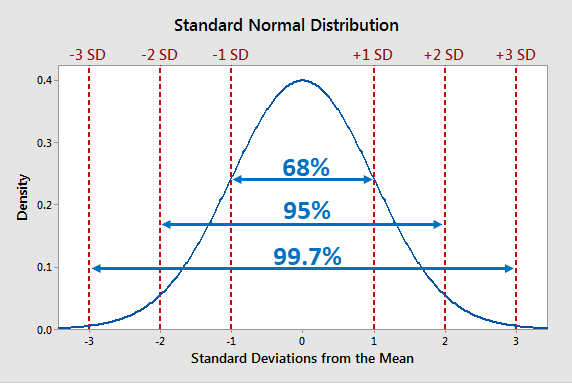

Source of Picture: https://statisticsbyjim.com/probability/empirical-rule/

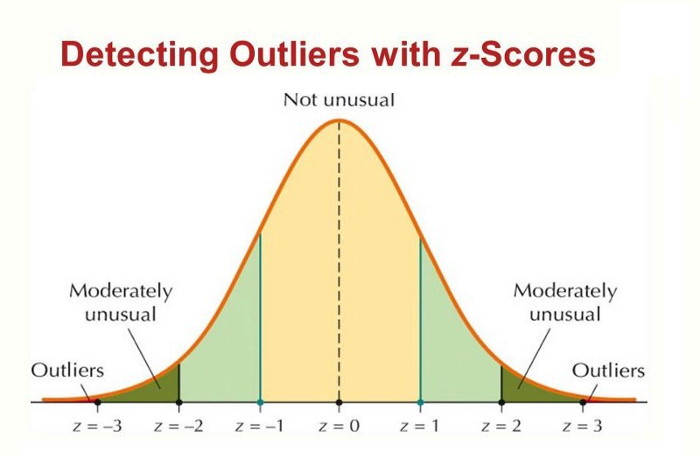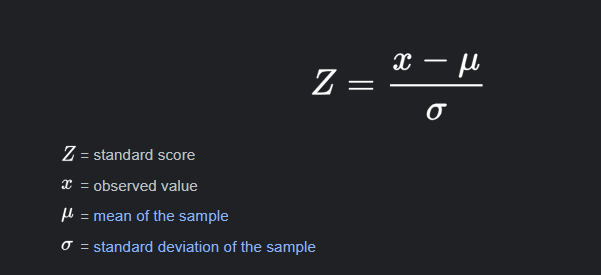

Source of picture: https://www.analyticsvidhya.com/blog/2022/08/dealing-with-outliers-using-the-z-score-method/

Disadvantage: It only works with the data which is completely or close to normally distributed. 
Additionally, mean of data point is very sensitive to the extreme values or outliers. 

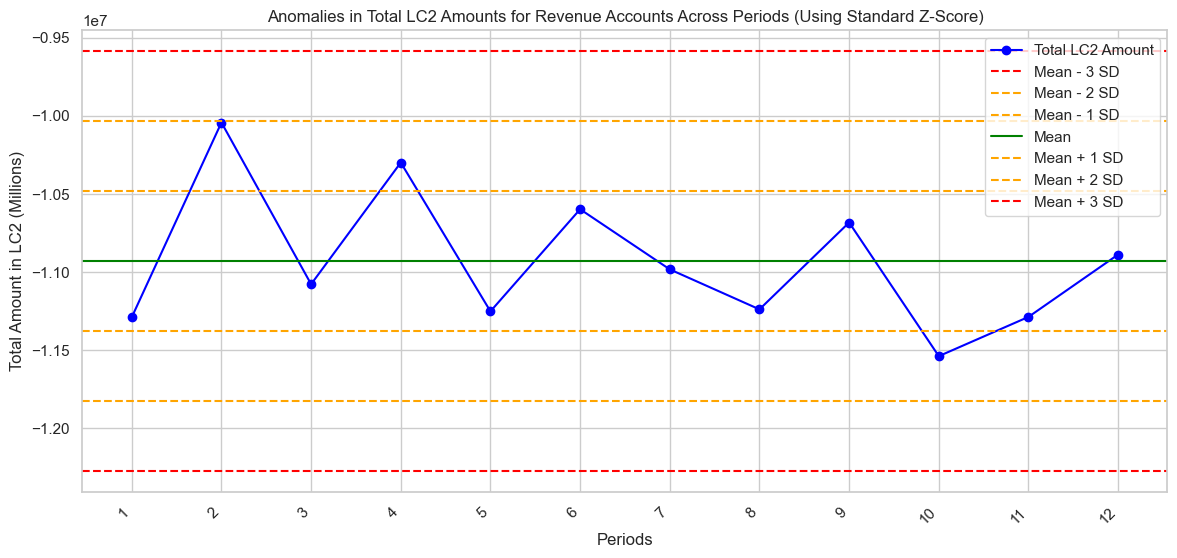

In [87]:
# Filter rows where GLAccount starts with '4' - Revenue Accounts
expense_df = df[df['GlAccount'].str.startswith('4')]

# Group by 'Period' and calculate the sum of 'AmountLC2_Val' for each period
sum_by_period = expense_df.groupby('Period')['AmountLC2_Val'].sum().reset_index()

# Calculate mean and standard deviation, handling NaN values
mean_val = sum_by_period['AmountLC2_Val'].mean(skipna=True)
std_dev = sum_by_period['AmountLC2_Val'].std(skipna=True)

# Calculate Standard Z-scores 
z_scores = (sum_by_period['AmountLC2_Val'] - mean_val) / std_dev

# Set the Z-score threshold 
zscore_threshold = 3

# Identify outliers based on Z-scores
outliers_zscore = (abs(z_scores) > zscore_threshold)

# Plot the data
plt.figure(figsize=(14, 6))
plt.plot(sum_by_period['Period'], sum_by_period['AmountLC2_Val'], marker='o', color='blue', label='Total LC2 Amount')
# Plot outliers
sns.scatterplot(x=sum_by_period[outliers_zscore]['Period'], y=sum_by_period[outliers_zscore]['AmountLC2_Val'],
                color='red', marker='x', s=100, label='Anomalies')

# Add lines for standard deviations
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() - zscore_threshold * std_dev, color='red', linestyle='--', label=f'Mean - {zscore_threshold} SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() - 2 * std_dev, color='orange', linestyle='--', label='Mean - 2 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() - std_dev, color='orange', linestyle='--', label='Mean - 1 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean(), color='green', linestyle='-', label='Mean')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() + std_dev, color='orange', linestyle='--', label='Mean + 1 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() + 2 * std_dev, color='orange', linestyle='--', label='Mean + 2 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() + zscore_threshold * std_dev, color='red', linestyle='--', label=f'Mean + {zscore_threshold} SD')


plt.title('Anomalies in Total LC2 Amounts for Revenue Accounts Across Periods (Using Standard Z-Score)')
plt.xlabel('Periods')
plt.ylabel('Total Amount in LC2 (Millions)')


plt.xticks(range(1, 13))  # FYI there might be period up to 16 due to adjustment made after fiscal year closing
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


1e7 = 1*pow(10,7) =  10.000.000

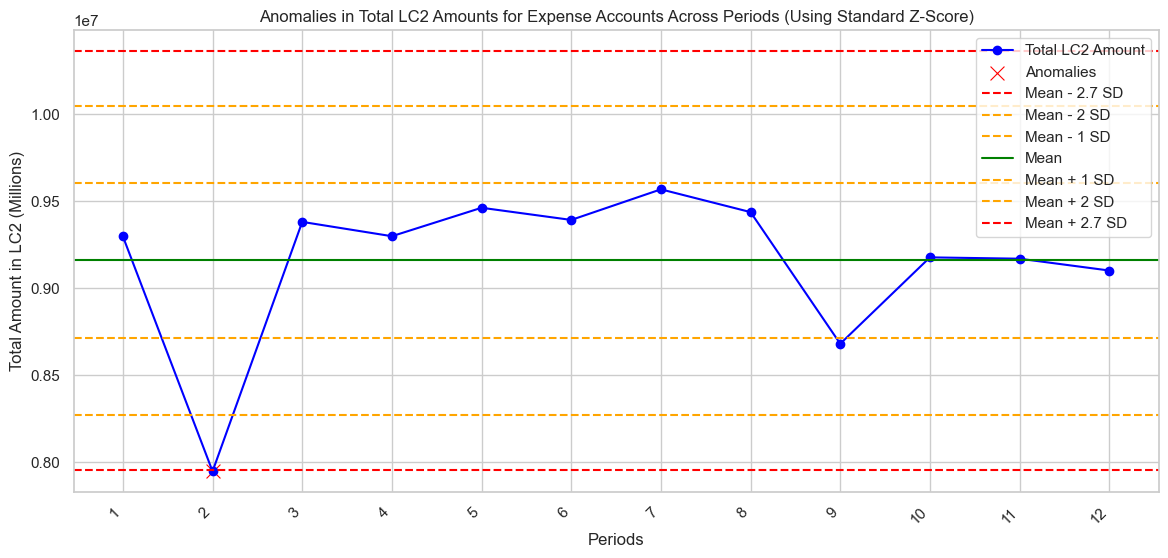

In [88]:
# Filter rows where GLAccount starts with '5' - Expense Accounts
expense_df = df[df['GlAccount'].str.startswith('5')]

# Group by 'Period' and calculate the sum of 'AmountLC2_Val' for each period
sum_by_period = expense_df.groupby('Period')['AmountLC2_Val'].sum().reset_index()

# Calculate mean and standard deviation, handling NaN values
mean_val = sum_by_period['AmountLC2_Val'].mean(skipna=True)
std_dev = sum_by_period['AmountLC2_Val'].std(skipna=True)

# Calculate Standard Z-scores 
z_scores = (sum_by_period['AmountLC2_Val'] - mean_val) / std_dev

# Set the Z-score threshold 
zscore_threshold = 2.7

# Identify outliers based on Z-scores
outliers_zscore = (abs(z_scores) > zscore_threshold)

# Plot the data
plt.figure(figsize=(14, 6))
plt.plot(sum_by_period['Period'], sum_by_period['AmountLC2_Val'], marker='o', color='blue', label='Total LC2 Amount')
# Plot outliers
sns.scatterplot(x=sum_by_period[outliers_zscore]['Period'], y=sum_by_period[outliers_zscore]['AmountLC2_Val'],
                color='red', marker='x', s=100, label='Anomalies')

# Add lines for standard deviations
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() - zscore_threshold * std_dev, color='red', linestyle='--', label=f'Mean - {zscore_threshold} SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() - 2 * std_dev, color='orange', linestyle='--', label='Mean - 2 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() - std_dev, color='orange', linestyle='--', label='Mean - 1 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean(), color='green', linestyle='-', label='Mean')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() + std_dev, color='orange', linestyle='--', label='Mean + 1 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() + 2 * std_dev, color='orange', linestyle='--', label='Mean + 2 SD')
plt.axhline(y=sum_by_period['AmountLC2_Val'].mean() + zscore_threshold * std_dev, color='red', linestyle='--', label=f'Mean + {zscore_threshold} SD')


plt.title('Anomalies in Total LC2 Amounts for Expense Accounts Across Periods (Using Standard Z-Score)')
plt.xlabel('Periods')
plt.ylabel('Total Amount in LC2 (Millions)')


plt.xticks(range(1, 13))  # FYI there might be period up to 16 due to adjustment made after fiscal year closing
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


with standard threshold of 3 and -3 there is no outliers

Upon employing a Z Score for revenue and expense accounts totals, no outliers were identified. 

If adjustments to the threshold are considered, it should be done consciously and accompanied by a clear finance or business rationale. Any changes to the threshold should align with the financial context and contribute meaningfully to the analysis.

In case of any huge variation (anomalies) historical data might be helpful to understand seasonality or other nuances in pattersn. 

##### Seeking Outliers/Anomalies in Data Points

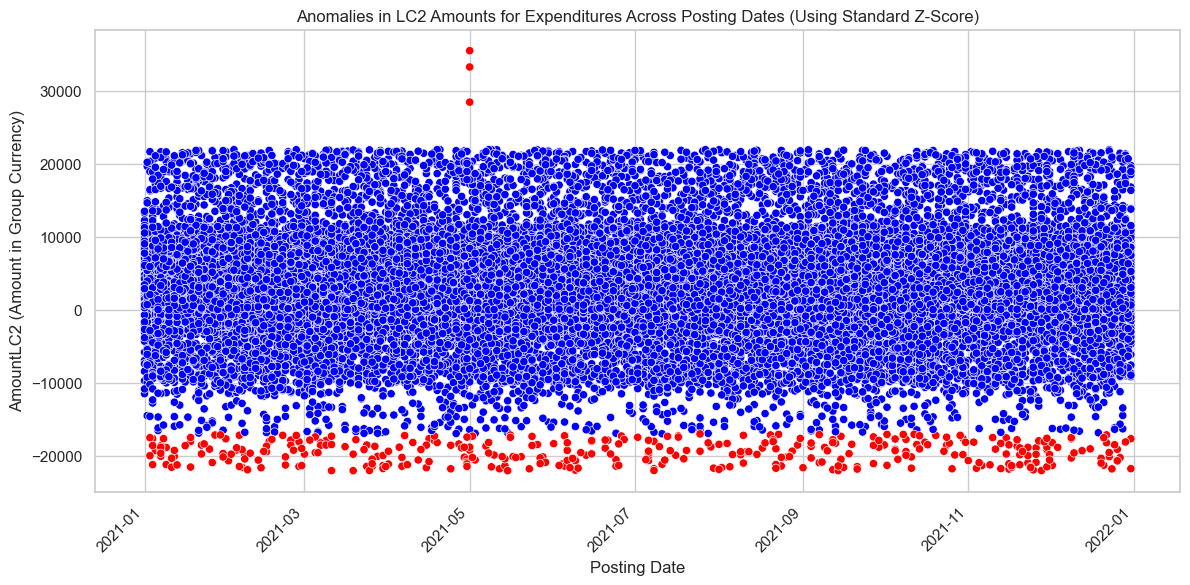

In [89]:
# You can also use Z Score to find outliers in all data points 
expense_df = df[df['GlAccount'].str.startswith('5')]  

# Calculate mean and standard deviation
mean_val = expense_df['AmountLC2_Val'].mean()
std_dev = expense_df['AmountLC2_Val'].std()
# Calculate Z-scores manually
z_scores = (expense_df['AmountLC2_Val'] - mean_val) / std_dev

# Set the Z-score threshold for identifying outliers
zscore_threshold = 3

# Identify outliers based on Z-scores
outliers_zscore = (abs(z_scores) > zscore_threshold)


plt.figure(figsize=(14, 6))
sns.scatterplot(x='PostDate', y='AmountLC2_Val', data=expense_df, hue=outliers_zscore, palette={False: 'blue', True: 'red'}, legend=False)

plt.title('Anomalies in LC2 Amounts for Expenditures Across Posting Dates (Using Standard Z-Score)')
plt.xlabel('Posting Date')
plt.ylabel('AmountLC2 (Amount in Group Currency)')

plt.xticks(rotation=45, ha='right')
plt.show()


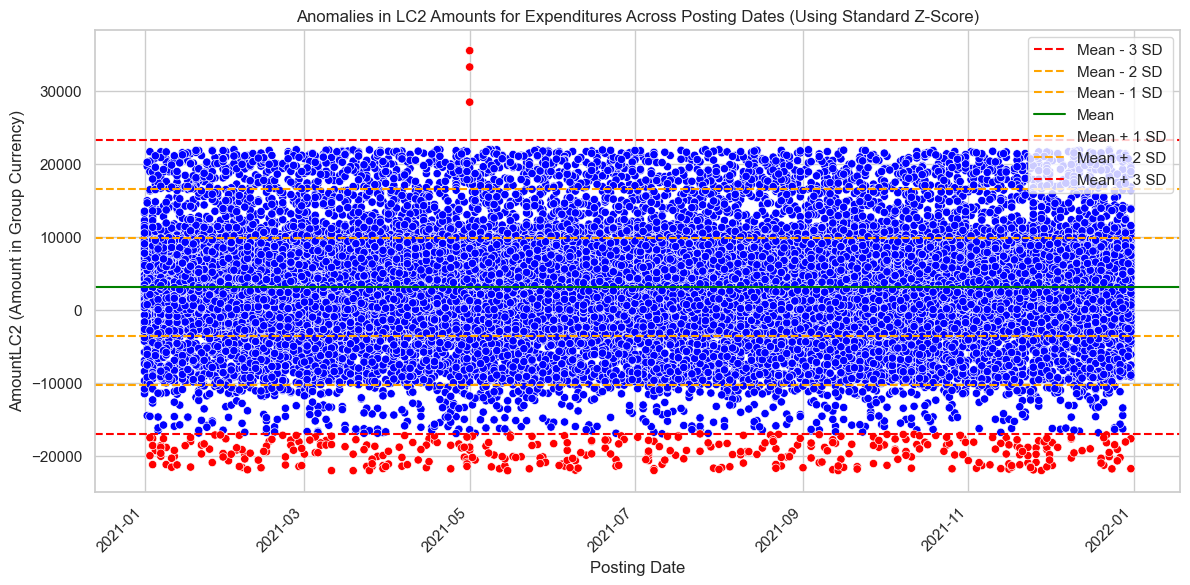

In [90]:
# Z-Score with Mean and SD lines

plt.figure(figsize=(14, 6))
sns.scatterplot(x='PostDate', y='AmountLC2_Val', data=expense_df, hue=outliers_zscore, palette={False: 'blue', True: 'red'}, legend=False)

# Add lines for standard deviations
plt.axhline(y=expense_df['AmountLC2_Val'].mean() - 3 * std_dev, color='red', linestyle='--', label='Mean - 3 SD')
plt.axhline(y=expense_df['AmountLC2_Val'].mean() - 2 * std_dev, color='orange', linestyle='--', label='Mean - 2 SD')
plt.axhline(y=expense_df['AmountLC2_Val'].mean() - std_dev, color='orange', linestyle='--', label='Mean - 1 SD')
plt.axhline(y=expense_df['AmountLC2_Val'].mean(), color='green', linestyle='-', label='Mean')
plt.axhline(y=expense_df['AmountLC2_Val'].mean() + std_dev, color='orange', linestyle='--', label='Mean + 1 SD')
plt.axhline(y=expense_df['AmountLC2_Val'].mean() + 2 * std_dev, color='orange', linestyle='--', label='Mean + 2 SD')
plt.axhline(y=expense_df['AmountLC2_Val'].mean() + 3 * std_dev, color='red', linestyle='--', label='Mean + 3 SD')

plt.title('Anomalies in LC2 Amounts for Expenditures Across Posting Dates (Using Standard Z-Score)')
plt.xlabel('Posting Date')
plt.ylabel('AmountLC2 (Amount in Group Currency)')

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


Those 3 journals might be incorrectly posted causing high expenditure balance in May. Need manual check of those items by experts.

Modified Z Score: 

Even if you data follows normal distribution, you must be very careful with Z-Score implementation because sometimes standard Z-Score can be not best approach since it uses mean of the data which is very sensitive to outliers. 

The modified Z Score, using Median and Median Absolute Deviation (MAD), is less sensitive to outliers compared to the standard Z Score, which utilizes Mean and Standard Deviation. 

Typically, a threshold of 3.5 for MAD is used to identify outliers in the case of the modified Z Score, while the standard Z Score employs a threshold of 3.0. This nuanced approach helps in robustly detecting outliers with the modified Z Score.

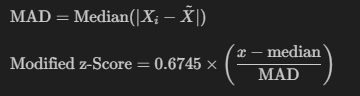

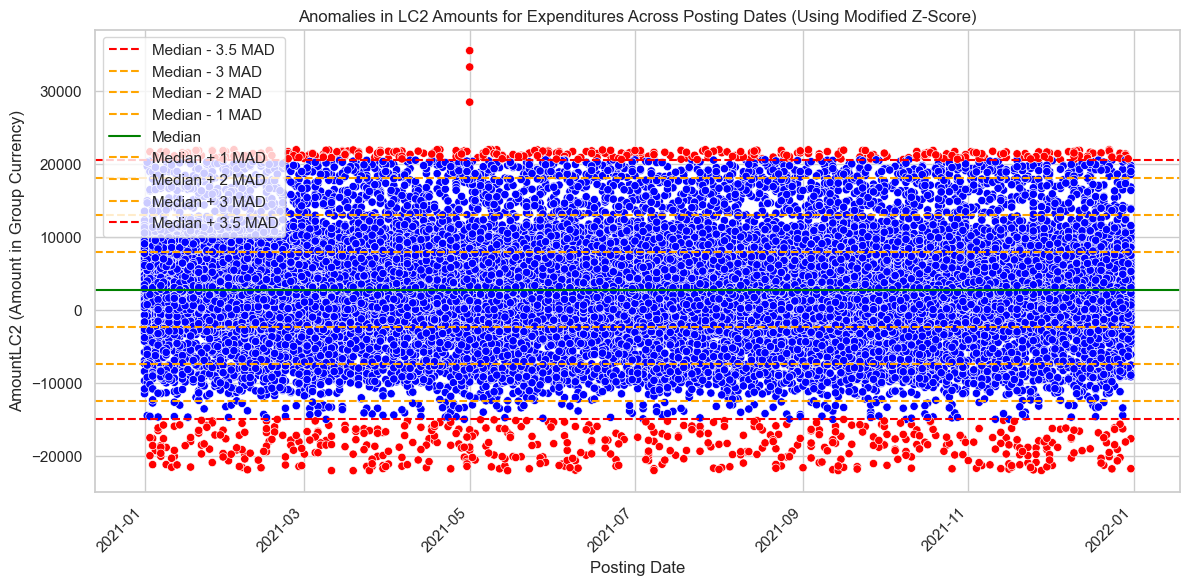

In [91]:
# Using Modified Z Score 
expense_df = df[df['GlAccount'].str.startswith('5')]

# Formula MAD = median (|x - median(x)|)  take every data point, substract it from median of the entire series, take the absolute value and take a median
median_abs_deviation =np.median(np.abs(expense_df['AmountLC2_Val'] - np.median(expense_df['AmountLC2_Val'])))  

#Formula Modified Z Score = 0.6745 * (x - median(x)) / MAD     #Calculated for every single data point
modified_z_scores = 0.6745 * (expense_df['AmountLC2_Val'] - np.median(expense_df['AmountLC2_Val'])) / median_abs_deviation

# Set the threshold for identifying outliers. 3.5 usually is good one. 
modified_zscore_threshold = 3.5

outliers_modified_zscore = (abs(modified_z_scores) > modified_zscore_threshold)
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.scatterplot(x='PostDate', y='AmountLC2_Val', data=expense_df, hue=outliers_modified_zscore, palette={False: 'blue', True: 'red'}, legend=False)
# Add lines for median and MAD
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) - (3.5 * median_abs_deviation)/0.6745, color='red', linestyle='--', label='Median - 3.5 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) - (3* median_abs_deviation)/0.6745, color='orange', linestyle='--', label='Median - 3 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) - (2* median_abs_deviation)/0.6745, color='orange', linestyle='--', label='Median - 2 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) - median_abs_deviation/0.6745, color='orange', linestyle='--', label='Median - 1 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val']), color='green', linestyle='-', label='Median')  # Solid red line for median
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) + median_abs_deviation/0.6745, color='orange', linestyle='--', label='Median + 1 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) + (2* median_abs_deviation)/0.6745, color='orange', linestyle='--', label='Median + 2 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val']) + (3* median_abs_deviation)/0.6745, color='orange', linestyle='--', label='Median + 3 MAD')
plt.axhline(y=np.median(expense_df['AmountLC2_Val'])+ (3.5* median_abs_deviation)/0.6745, color='red', linestyle='--', label='Median + 3.5 MAD')

plt.title('Anomalies in LC2 Amounts for Expenditures Across Posting Dates (Using Modified Z-Score)')
plt.xlabel('Posting Date')
plt.ylabel('AmountLC2 (Amount in Group Currency)')

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


NOTE: the mean is more sensitive to outliers than the median. Sensitivity to outliers indicates how much a measure of central tendency is influenced by extreme values in the data.

Interquartile Range (IQR):

The IQR method is widely used for identifying outliers and more. This method should be explained together with boxplots.

A boxplot provides a standardized representation of data distribution, based on a five-number summary: the minimum, the maximum, the sample median, and the first and third quartiles (Q1 and Q3). By using boxplots method, you can get summary values of data distribution including skewness, you get pinpoint outliers and/or use it for comparing different features. 

InterQuartile Range (IQR) which is containing 50% of data in the middle is a range between first (Q1) and third (Q3) quartiles.

The whiskers extended from the Q1 and Q3 are showing the range of the data. There are many ways to  define length of whiskers, but traditional way is to use 1.5 times of the IQR and to add it to both ends of the box. Those data points that will be beyond those whiskers will be considered as outliers.  

IQR Advantage: The IQR method is non-parametric which means your data doesn't necessarily to be with normal distribution. Also it is less sensitive to extreme values or outliers comparing to standard Z-Score. 
IQR Disadvantage: It is ineffective for multimodal distributions characterized by multiple peaks

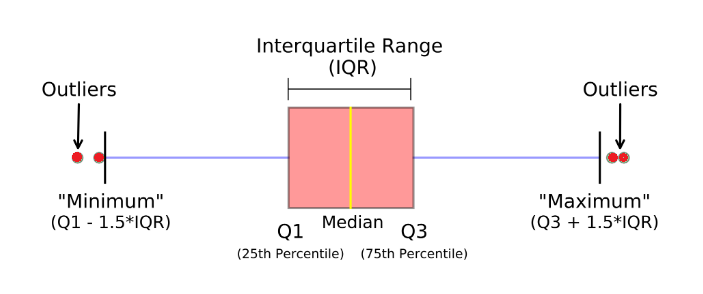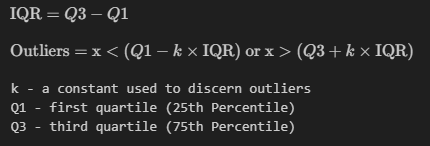
<br> Source of picture: https://www.kdnuggets.com/2019/11/understanding-boxplots.html

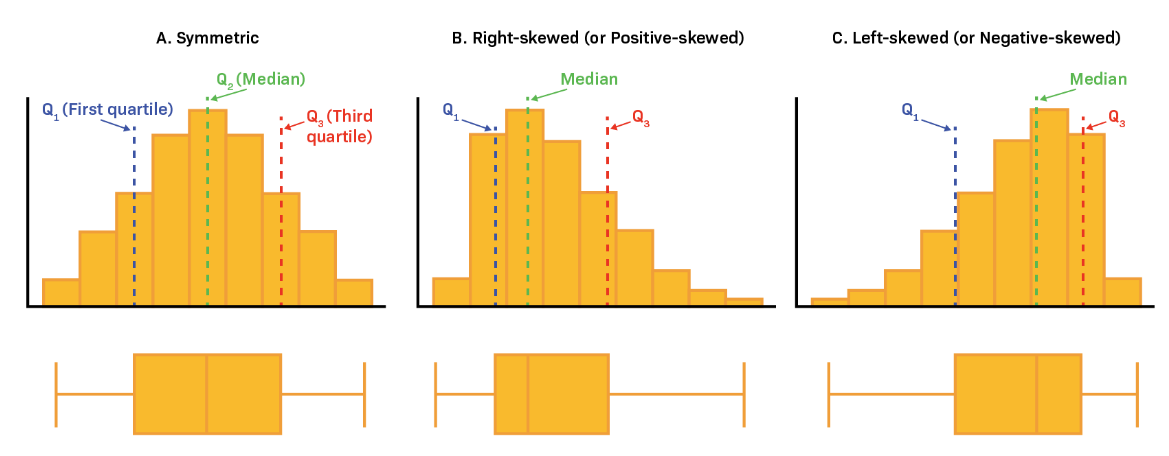
<br> Source of picture: https://www.labxchange.org/library/items/lb:LabXchange:d8863c77:html:1

In [92]:
# Interquartile Range (IQR) method for anomaly detection (example on Revenue Trtansactions)
revenue_df = df[df['GlAccount'].str.startswith('4')]

# Calculate IQR
q1 = revenue_df['AmountLC2_Val'].quantile(0.25)
q3 = revenue_df['AmountLC2_Val'].quantile(0.75)
iqr = q3 - q1

# Multiplying Factor
factor = 1.5

# Identify outliers
outliers_iqr = ((revenue_df['AmountLC2_Val'] < (q1 - factor * iqr)) | (revenue_df['AmountLC2_Val'] > (q3 + factor * iqr)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


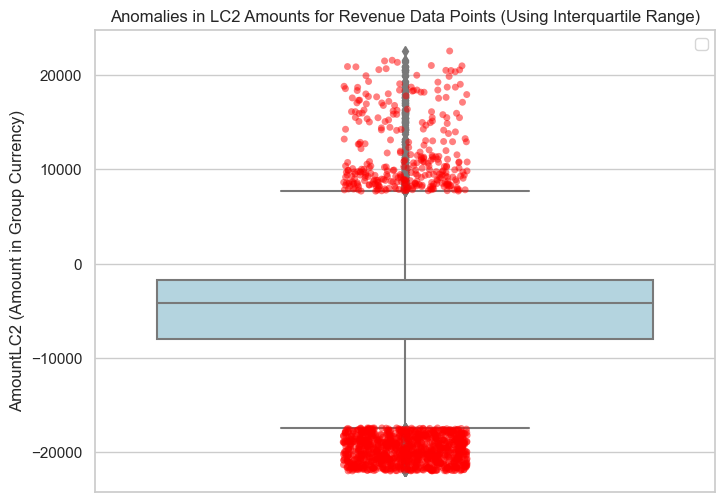

In [93]:
# Box Plots Visual
plt.figure(figsize=(8, 6))
sns.boxplot(y=revenue_df['AmountLC2_Val'], color='lightblue')

# Mark outliers with red dots
sns.stripplot(y=revenue_df['AmountLC2_Val'][outliers_iqr], color='red', size=5, alpha=0.5)


# Lines
#plt.axhline(y=(q3 + factor * iqr), color='red', linestyle='--', label='Upper Limit')
#plt.axhline(y=q3, color='orange', linestyle='--', label='q3')
#plt.axhline(y=revenue_df['AmountLC2_Val'].quantile(0.50), color='green', linestyle='--', label='q2 (Median)')
#plt.axhline(y=q1, color='orange', linestyle='--', label='q1')
#plt.axhline(y=(q1 - factor * iqr), color='red', linestyle='--', label='Lower Limit')


plt.title('Anomalies in LC2 Amounts for Revenue Data Points (Using Interquartile Range)')
plt.ylabel('AmountLC2 (Amount in Group Currency)')
plt.legend()
plt.show()

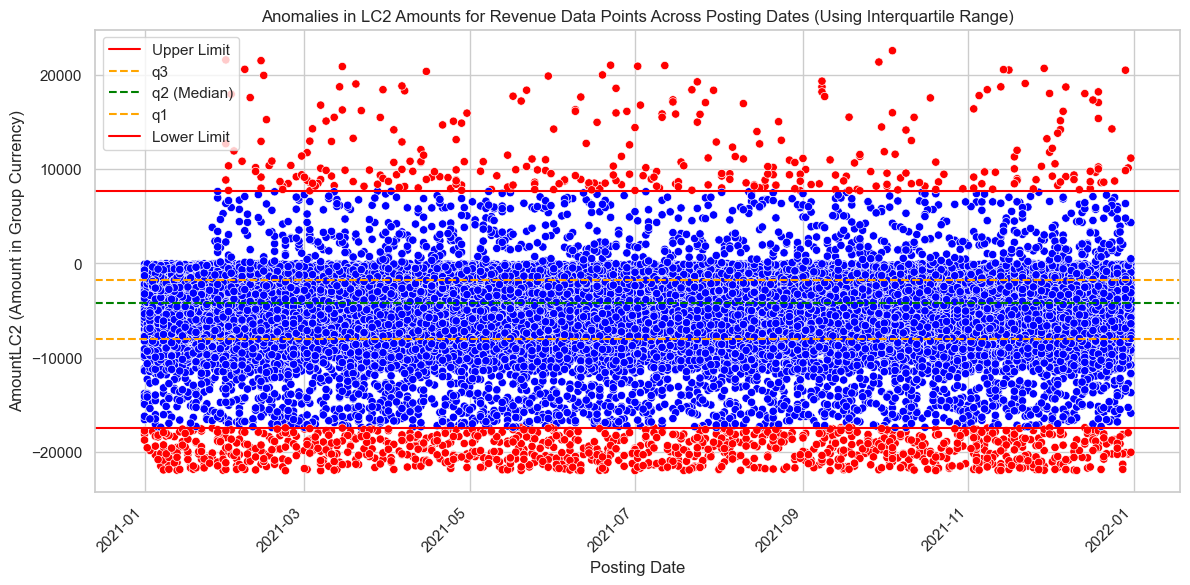

In [94]:
# Using Scatterplot Visual and Posting Date feature
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.scatterplot(x='PostDate', y='AmountLC2_Val', data=revenue_df, hue=outliers_iqr, palette={False: 'blue', True: 'red'}, legend=False)
plt.axhline(y=(q3 + factor * iqr), color='red', linestyle='-', label='Upper Limit')
plt.axhline(y=q3, color='orange', linestyle='--', label='q3')
plt.axhline(y=revenue_df['AmountLC2_Val'].quantile(0.50), color='green', linestyle='--', label='q2 (Median)')
plt.axhline(y=q1, color='orange', linestyle='--', label='q1')
plt.axhline(y=(q1 - factor * iqr), color='red', linestyle='-', label='Lower Limit')

plt.title('Anomalies in LC2 Amounts for Revenue Data Points Across Posting Dates (Using Interquartile Range)')
plt.xlabel('Posting Date')
plt.ylabel('AmountLC2 (Amount in Group Currency)')

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


Since for Revenue accounts debit (positive) postings are more unusual we will focus on outliers above Upper Limit, but there might be unusual posting done with higher materiality and credit sign as well.

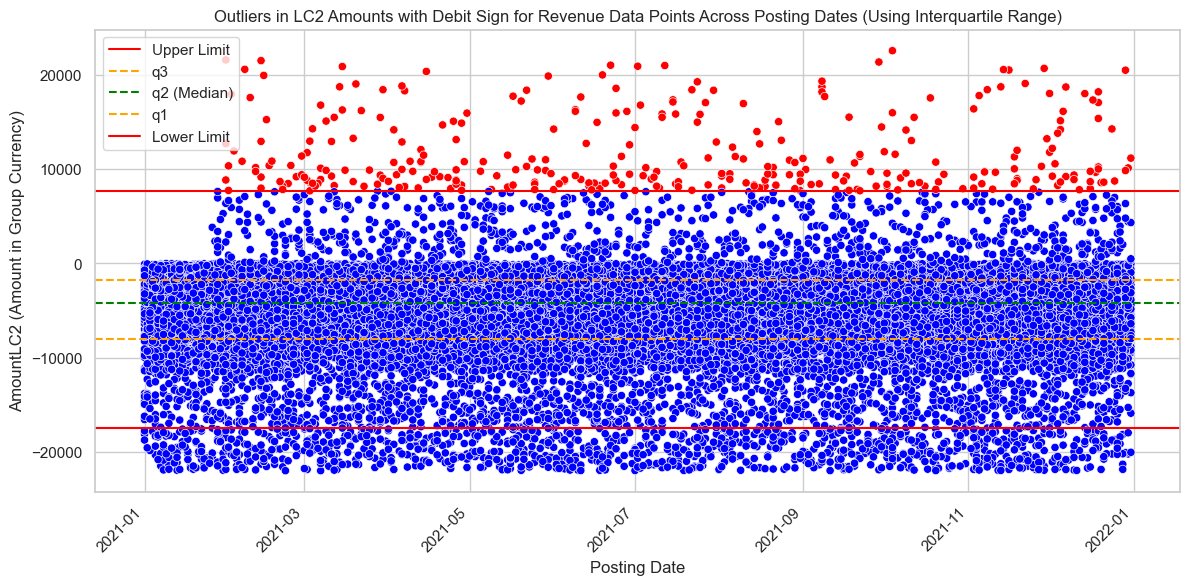

In [95]:
# removing data points below  lower Limit
outliers_iqr = ((revenue_df['AmountLC2_Val'] > (q3 + factor * iqr)))

plt.figure(figsize=(14, 6))
sns.scatterplot(x='PostDate', y='AmountLC2_Val', data=revenue_df, hue=outliers_iqr, palette={False: 'blue', True: 'red'}, legend=False)
plt.axhline(y=(q3 + factor * iqr), color='red', linestyle='-', label='Upper Limit')
plt.axhline(y=q3, color='orange', linestyle='--', label='q3')
plt.axhline(y=revenue_df['AmountLC2_Val'].quantile(0.50), color='green', linestyle='--', label='q2 (Median)')
plt.axhline(y=q1, color='orange', linestyle='--', label='q1')
plt.axhline(y=(q1 - factor * iqr), color='red', linestyle='-', label='Lower Limit')

plt.title('Outliers in LC2 Amounts with Debit Sign for Revenue Data Points Across Posting Dates (Using Interquartile Range)')
plt.xlabel('Posting Date')
plt.ylabel('AmountLC2 (Amount in Group Currency)')

plt.xticks(rotation=45, ha='right')

plt.legend()
plt.show()

In [96]:
# adding new feature for visualization of entity revenue lines
revenue_df["Client_CCode"] = revenue_df.Client.astype(str) + revenue_df.CompCode.astype(str)

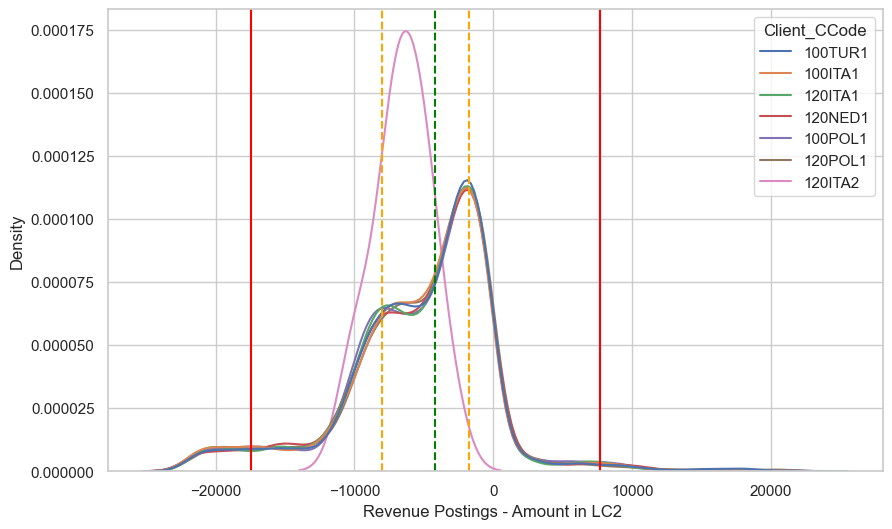

In [97]:
# Create KDE plots for all Client_CCode values
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=revenue_df, x='AmountLC2_Val',  common_norm=False, hue='Client_CCode')

plt.axvline(x=(q3 + factor * iqr), color='red', linestyle='-')#, label='Upper Limit')
plt.axvline(x=q3, color='orange', linestyle='--')#, label='q3')
plt.axvline(x=revenue_df['AmountLC2_Val'].quantile(0.50), color='green', linestyle='--')# label='q2 (Median)')
plt.axvline(x=q1, color='orange', linestyle='--')# label='q1')
plt.axvline(x=(q1 - factor * iqr), color='red', linestyle='-')# label='Lower Limit')
plt.xlabel('Revenue Postings - Amount in LC2 ')
plt.show()

In this specific example, data points to the right of the right red line (IQR Upper Limit) are potential outliers (material debit postings in revenue account), requiring further checking the factors contributing to their unusual behavior.

On the other hand, the pink-colored entity postings (120-ITA2) appear relatively normal, with predominantly credit entries—a correct pattern for revenue. 

let's examine the percentage of abnormal items in the total for each entity. 

In [98]:
revenue_df.loc[revenue_df['AmountLC2_Val'] > (q3 + factor * iqr), "Anom"] = "Anomaly"
revenue_df["Anom"] = revenue_df["Anom"].fillna("Normal")

In [99]:
revenue_df["Anom"].value_counts(dropna=False)

Normal     24799
Anomaly      322
Name: Anom, dtype: int64

In [100]:
#Total Potential Anomalies per Entities
value_counts = revenue_df.groupby(['Client_CCode', 'Anom']).size()
counts_df = pd.DataFrame(value_counts, columns=['Count'])
counts_df.reset_index(inplace=True)

pivot_df = counts_df.pivot(index='Client_CCode', columns='Anom', values='Count')

pivot_df.fillna(0, inplace=True)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df['Contam%'] = pivot_df['Anomaly'] / pivot_df['Total']
pivot_df

Anom          Anomaly  Normal   Total   Contam%
Client_CCode                                   
100ITA1          66.0  4959.0  5025.0  0.013134
100POL1          51.0  3969.0  4020.0  0.012687
100TUR1          72.0  4958.0  5030.0  0.014314
120ITA1          57.0  4958.0  5015.0  0.011366
120ITA2           0.0    12.0    12.0  0.000000
120NED1          40.0  2969.0  3009.0  0.013293
120POL1          36.0  2974.0  3010.0  0.011960

Exploring other statistical methods (also machine learning algorithms) can further enhance anomaly detection. Engineering additional features like GL flows (Dr-Cr amounts between GL Accountss), document counts, nature of GL accounts and nature of postings, risk level of accounts and transactions, combinations of other fields, and others can enhance further the identification of abnormalities in accounting transactions. 

The approach to data transformation, feature engineering, and fine-tuning (for ML Projects) depends on the specific questions you aim to address. 

Thank you and good luck!